## Imports & Helpers

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../../')
from checkmate_imports import *

# global variables 
HUE_ORDER = ['stroma','pred_g2','intermediate_grade','pred_g4']
MIN_SEGMENT_SIZE = 50
GRADE_DIFF_THRESH = 0.35
TUMOR_DIFF_THRESH = 0.35
MIN_TUMOR_SEG_MEAN = 0.70
NODE_DIFF_CUTOFF = invert_rag_weight(GRADE_DIFF_THRESH) 
MIN_TIL_COUNT = 10

# GRADE_TC_CUTOFF = 0.4  # minimum segment mean grade score to consider in TIL processing 
# GRADE_TC_CUTOFF = 0.  # minimum segment mean grade score to consider in TIL processing 
GRADE_TC_CUTOFF = 0.8  # focusing on high grade foci only 

print('MODIFYING EARLIER TIL CUTOFFS')
TIL_ISO_CUTOFF = 14  # based on none vs any AUROC bootstrap on high grade foci + no hard cases
TIL_HIGH_CUTOFF = 48 # based on not-high vs high AUROC bootstrap on high grade foci + no hard cases
FRAC_CUTOFF = 0.25
TIL_AREA_CUTOFF = 10

EXCLUSION_RATIO_CUTOFF = 1.5  # margin vs center ratio threshold for "exclusion" call
TILES_PER_MM2 = 0.256**-2

# assume 7x7 minimum case for a square area focus
# going 2 tiles inner would result in a 5x5 inner cube and thus area cutoff of 25
# MIN_CENTER_AREA = 25
MIN_CENTER_AREA = 10  # relaxing from 25 to try to recover possible interesting foci

MODIFYING EARLIER TIL CUTOFFS


In [2]:
from lifelines.statistics import pairwise_logrank_test, multivariate_logrank_test, survival_difference_at_fixed_point_in_time_test
from copy import deepcopy

In [3]:
def filter_multiple_cph_results(result_dict, formula, threshold=0.2):
    """
    Returns subsetted summary DataFrame of coefficients filtered below `threshold` p-val 
    """
    filtered = {}
    for split, outs in result_dict.items():
        single_out = outs[formula].summary
        filtered[split] = single_out.loc[single_out['p'] < threshold]
        filtered[split]['formula'] = formula
        filtered[split]['split'] = split

    return filtered

### Load saved files 

In [4]:
# feature_subset = pd.read_csv('./rerun_final_patient_features.csv', index_col=0)
feature_subset = pd.read_csv('./rerun_final_patient_features_RICKETTS_FILTER.csv', index_col=0)

anno = pd.read_csv('manual_cm025_merged_braunsupp_annotations.csv') 
anno['unique_id'] = 'cm025_' + anno.subjid.astype(str)
paper_desert = anno.loc[anno.ImmunoPhenotype == 'Desert','unique_id'].values
paper_infl = anno.loc[anno.ImmunoPhenotype == 'Infiltrated','unique_id'].values
paper_excl = anno.loc[anno.ImmunoPhenotype == 'Excluded','unique_id'].values
anno = anno.set_index('unique_id')

node_descriptions = pd.read_csv('./rerun_node_descriptions_with_score_components.csv',index_col=[0])
node_descriptions['merged_labels'] = node_descriptions['merged_labels'].astype(int)

prox_dist_edges = pd.read_csv('./rerun_proximal_and_distal_edge_annotations_with_score_components.csv',index_col=0)

scores = pd.read_csv('./rerun_slidewise_grade_til_scores.csv', index_col=0)

load_tile_info = False

if load_tile_info:
    tilewise_anno = pd.read_csv('./rerun_tilewise_grade_til_annotations.csv', index_col=0) # TIL specific CM025 subset

    edge_info = pd.read_csv('./rerun_base_rag_edge_info_annotation.csv', index_col=[0,1,2,3])
    # restore set objects (stored as string when saved to csv earlier)
    edge_info['edge_set'] = edge_info.reset_index()[['edge0','edge1']].apply(lambda x: set(x),1).values

    # read in non-TIL tilewise info 
    seg_agg = pd.read_csv('./rerun_tilewise_grade_nontil_annotations.csv', index_col=0)
    
    edge_agg_pivot = pd.read_csv('./rerun_base_rag_edge_info_annotation_processed.csv', index_col=[0,1,2])
    edge_class_sum = pd.read_csv('./rerun_base_rag_edge_info_annotation_processed_sum.csv', index_col=0)
    edge_binary = edge_class_sum > 0

In [5]:
feature_subset['combined_f_weighted_edge_score'] = feature_subset['edge_class_proximal_f_weighted'] + feature_subset['edge_class_distal_f_weighted']
feature_subset['combined_total_weighted_edge_score'] = feature_subset['edge_class_proximal_total_weighted'] + feature_subset['edge_class_distal_total_weighted']

#### Grab Bi supplement again

In [6]:
kbi_supp_tcga = pd.read_excel('/home/jupyter/TableS5_Submit.xlsx', sheet_name=3, header=1).set_index(['Patient'])

final_supp = pd.read_excel('/home/jupyter/TableS5_ReSubmit_FInalized.xlsx', sheet_name=2, header=1)
final_supp['subjid'] = final_supp['SUBJID'].apply(lambda x: x.split('-')[1])

prev_cm025_scores = final_supp.set_index('subjid')[['TP1 Score', 'TP2 Score', 'Immune Checkpoint/Evasion Score']]
prev_cm025_scores.index = 'cm025_' + prev_cm025_scores.index.astype(str)
prev_scores = pd.concat([kbi_supp_tcga[['TP1 Score', 'TP2 Score',]], prev_cm025_scores])
    
prev_comparison = feature_subset.copy()
prev_comparison = prev_comparison.join(prev_scores)
prev_comparison['tp1_tp2_diff_prev'] = prev_comparison['TP1 Score']- prev_comparison['TP2 Score']

#### Grab Braun supplement again

In [7]:
final_supp = final_supp.set_index('subjid')
final_supp.index = 'cm025_' + final_supp.index.astype(str)
final_supp['tp1_high'] = final_supp['TP1 Score'] > final_supp['TP1 Score'].median()
final_supp = final_supp.join(anno['PBRM1'])

final_supp['n_prio_tx_above_1'] = final_supp['Number_of_Prior_Therapies'] > 1
final_supp['n_prio_tx_above_1'] = final_supp['n_prio_tx_above_1'].astype(str)

final_supp.index.name = 'unique_id'

#### Read Braun RNA data and merge

In [8]:
rna = pd.read_csv('/home/jupyter/checkmate-histo/consolidated_workflow/braun2020_rna_only.csv', index_col=0).transpose()
rna.index.name = 'fid'

index_key = reset_set_idx(final_supp, 'Sample')['unique_id']
paired_rna = rna.join(index_key).dropna(subset=['unique_id'])
paired_rna = paired_rna.set_index('unique_id')

#### Merge and reformat

In [9]:
feature_subset = merge_nonoverlapping(feature_subset, prev_scores)
feature_subset = feature_subset.join(anno[['Received_Prior_Therapy','Days_from_TumorSample_Collection_and_Start_of_Trial_Therapy']])

feature_subset['tp1_score'] = feature_subset['TP1 Score']
feature_subset['tp2_score'] = feature_subset['TP2 Score']

feature_subset = feature_subset.join(anno['Number_of_Prior_Therapies'])

feature_subset.loc[feature_subset['Number_of_Prior_Therapies'] <= 1, 'n_prior_therapy'] = 'one_or_less'
feature_subset.loc[feature_subset['Number_of_Prior_Therapies'] > 1, 'n_prior_therapy'] = 'more_than_one'

feature_subset['tp1_available'] = ~feature_subset['TP1 Score'].isna()

### Override previous infiltration cutoffs to simply be based on median 

In [10]:
prev = prepare_cm025_subset(feature_subset, anno=anno, drug_type='any', relabel_edge_cats=True, qbins=2, mandatory_vars=[])

selecting cm025 only
(623, 160)
dropping unusable data (grade seg based)
(569, 160)
dropping entries missing any in ['os', 'os_event']
renaming updated_nonstroma_grade_mean to nonstroma_grade_mean temporarily
(558, 160)
grade quantile bins:  [0.15729222 0.77056246 0.9979857 ]
(558, 161)
dropping low tumor tile count cases
(558, 161)
dropping G1 [keeping unannotated cases]
(557, 161)
dropping metastatic biopsies
(439, 161)
keeping all stages 
(439, 161)
only keeping cases MSKCC risk group annotation
(439, 162)
converting bool edge presence labels to string


In [11]:
prev['all_nodes_area_weighted'].dropna().median()

0.1585503963759909

In [12]:
prev.groupby(['global_infiltration_bin'])['all_nodes_area_weighted'].describe()

,count,mean,std,min,25%,50%,75%,max
global_infiltration_bin,,,,,,,,
high_hg_global_infiltration,176.0,0.370849,0.247098,0.057034,0.157776,0.337544,0.543110,0.969733
low_hg_global_infiltration,87.0,0.017764,0.016090,0.000000,0.004593,0.013818,0.030297,0.055446
no_hg_present,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
MEDIAN_HG_INF_CUTOFF = 0.15855
print(f'Setting Area Infiltration Cutoff to be {MEDIAN_HG_INF_CUTOFF} based on Median')

Setting Area Infiltration Cutoff to be 0.15855 based on Median


In [14]:
crit = (feature_subset['cohort'] == 'cm025') & (feature_subset['usable_til_data']) & (feature_subset['all_nodes_area_weighted'] < MEDIAN_HG_INF_CUTOFF)

In [15]:
feature_subset.loc[crit, 'global_infiltration_bin'] = 'low_hg_global_infiltration'

In [16]:
update = prepare_cm025_subset(feature_subset, anno=anno, drug_type='any', relabel_edge_cats=True, qbins=2, mandatory_vars=[])

selecting cm025 only
(623, 160)
dropping unusable data (grade seg based)
(569, 160)
dropping entries missing any in ['os', 'os_event']
renaming updated_nonstroma_grade_mean to nonstroma_grade_mean temporarily
(558, 160)
grade quantile bins:  [0.15729222 0.77056246 0.9979857 ]
(558, 161)
dropping low tumor tile count cases
(558, 161)
dropping G1 [keeping unannotated cases]
(557, 161)
dropping metastatic biopsies
(439, 161)
keeping all stages 
(439, 161)
only keeping cases MSKCC risk group annotation
(439, 162)
converting bool edge presence labels to string


In [17]:
update.groupby(['global_infiltration_bin'])['all_nodes_area_weighted'].describe()

,count,mean,std,min,25%,50%,75%,max
global_infiltration_bin,,,,,,,,
high_hg_global_infiltration,132.0,0.459134,0.223431,0.15855,0.248671,0.400099,0.619838,0.969733
low_hg_global_infiltration,131.0,0.047398,0.046386,0.00000,0.008805,0.030429,0.087560,0.155452
no_hg_present,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


---
### CPH [pulling from 20210701NB & 20210723NB]

#### Define groups of features and create formulas 

In [18]:
# VSIR: C10orf54
evasion_genes = ['C10orf54','VSIG4','LGALS9','CD274','PDCD1LG2','SIGLEC10','NECTIN2','CD47','MIF']

---

### Meta sweep: multiple regularization strengths

In [19]:
unscaled_cols = ['nonstroma_grade_mean','age_at_diagnosis','edge_class_proximal_f_weighted','edge_class_distal_f_weighted',
                 'all_nodes_area_weighted','edge_class_proximal_total_weighted','edge_class_distal_total_weighted', 'total_nodes',
                'combined_f_weighted_edge_score','combined_total_weighted_edge_score']
fill_cols = unscaled_cols

In [20]:
# aggregate_formulas = [
#     'grade', # univariate baseline 1
#     'nonstroma_grade_mean', # univariate baseline 2
#     'age_at_diagnosis + gender + n_prior_therapy', # simple baseline
#     'grade + age_at_diagnosis + gender + n_prior_therapy', # simple baseline 2
#     'nonstroma_grade_mean + age_at_diagnosis + gender + n_prior_therapy', # simple baseline 3
#     'MSKCC + grade + age_at_diagnosis + gender + n_prior_therapy', # clinical only max details

#     'n_prior_therapy + age_at_diagnosis + gender + any_hg_diff_edge : global_infiltration_bin + nonstroma_grade_mean',
#     'n_prior_therapy + age_at_diagnosis + gender + combined_total_weighted_edge_score : any_hg_diff_edge : global_infiltration_bin + nonstroma_grade_mean',
#     'n_prior_therapy + age_at_diagnosis + gender + combined_total_weighted_edge_score : global_infiltration_bin + nonstroma_grade_mean',
#     'n_prior_therapy + age_at_diagnosis + gender + combined_total_weighted_edge_score + any_hg_diff_edge : global_infiltration_bin + nonstroma_grade_mean',

#     'any_hg_diff_edge : global_infiltration_bin + nonstroma_grade_mean',
#     'combined_total_weighted_edge_score : any_hg_diff_edge : global_infiltration_bin + nonstroma_grade_mean',
#     'combined_total_weighted_edge_score : global_infiltration_bin + nonstroma_grade_mean',
#     'combined_total_weighted_edge_score + any_hg_diff_edge : global_infiltration_bin + nonstroma_grade_mean',
    
#     'MSKCC + n_prior_therapy + age_at_diagnosis + gender + any_hg_diff_edge : global_infiltration_bin + nonstroma_grade_mean',
#     'MSKCC + n_prior_therapy + age_at_diagnosis + gender + combined_total_weighted_edge_score : any_hg_diff_edge : global_infiltration_bin + nonstroma_grade_mean',
#     'MSKCC + n_prior_therapy + age_at_diagnosis + gender + combined_total_weighted_edge_score : global_infiltration_bin + nonstroma_grade_mean',
#     'MSKCC + n_prior_therapy + age_at_diagnosis + gender + combined_total_weighted_edge_score + any_hg_diff_edge : global_infiltration_bin + nonstroma_grade_mean',
# ]

aggregate_formulas = [
    'MSKCC + grade + age_at_diagnosis + gender + n_prior_therapy', # clinical only max details
    
    'any_hg_diff_edge + all_nodes_area_weighted + nonstroma_grade_mean',
    'any_hg_diff_edge + global_infiltration_bin + nonstroma_grade_mean',
    'any_hg_diff_edge : global_infiltration_bin + nonstroma_grade_mean',
    'combined_total_weighted_edge_score + any_hg_diff_edge + all_nodes_area_weighted + nonstroma_grade_mean',
    'combined_total_weighted_edge_score + any_hg_diff_edge + global_infiltration_bin + nonstroma_grade_mean',
    'combined_total_weighted_edge_score + all_nodes_area_weighted + any_hg_diff_edge : nonstroma_grade_mean',
    
    'MSKCC + age_at_diagnosis + gender + n_prior_therapy + any_hg_diff_edge + all_nodes_area_weighted + nonstroma_grade_mean',
    'MSKCC + age_at_diagnosis + gender + n_prior_therapy + any_hg_diff_edge + global_infiltration_bin + nonstroma_grade_mean',
    'MSKCC + age_at_diagnosis + gender + n_prior_therapy + any_hg_diff_edge : global_infiltration_bin + nonstroma_grade_mean',
    'MSKCC + age_at_diagnosis + gender + n_prior_therapy + combined_total_weighted_edge_score + any_hg_diff_edge + all_nodes_area_weighted + nonstroma_grade_mean',
    'MSKCC + age_at_diagnosis + gender + n_prior_therapy + combined_total_weighted_edge_score + any_hg_diff_edge + global_infiltration_bin + nonstroma_grade_mean',
    'MSKCC + age_at_diagnosis + gender + n_prior_therapy + combined_total_weighted_edge_score + all_nodes_area_weighted + any_hg_diff_edge : nonstroma_grade_mean',
]

In [21]:
outcome_type = 'recist'
duration_var = 'pfs'
risk_type = 'MSKCC'
mandatory_vars = ['age_at_diagnosis','gender','n_prior_therapy','all_nodes_area_weighted']
til_only_cases = True
drop_met_site = False
event_var = duration_var+'_event'
gene = None
high_grade_filter = True
qbins = 2

fill_value = 0.

reg_sweep = {
#     'none':{'penalizer':0, 'l1_ratio':0},
    'default':{'penalizer':0.1, 'l1_ratio':0.1},
#     'stricter_050':{'penalizer':0.50, 'l1_ratio':0.1},
}

In [22]:
%%capture
data_subset = feature_subset.copy()

try:
    client.close()
except:
    pass

client = Client()

store = []
completed = []  
filtered_data_store = {}
meta_agg = []

for sweep_id, sweep_params in reg_sweep.items():
    for outcome_type in ['benefit']:
        for duration_var in ['os','pfs']:
            event_var = duration_var+'_event'
            for drop_intermed_group in [False]:
                for drug_type in ['ICI','Non-ICI']:
                    split_name = f'{duration_var}_{drug_type}_only' if drug_type != 'any' else 'all_data'
                    if outcome_type == 'recist':
                        split_name += f'_dropped_stable_disease' if drop_intermed_group else '_including_stable_disease'
                    else:
                        split_name += f'_dropped_intermediate_benefit' if drop_intermed_group else '_including_intermediate_benefit'

                    temp = prepare_cm025_subset(data_subset, anno=anno, drug_type=drug_type, mandatory_vars=mandatory_vars,
                                                duration_var=duration_var, outcome_type=outcome_type, til_only_cases=til_only_cases, 
                                                risk_type=risk_type, drop_met_site=drop_met_site,
                                                gene=gene, drop_intermed_group=drop_intermed_group,
                                               high_grade_filter=high_grade_filter, qbins=qbins)
                    

                    temp['any_diff_edge'] = temp['any_diff_edge'].map({'No Mixed Foci Presence':'Homogeneous','Low/Hi Presence':'Heterogeneous'})
                    temp['any_hg_diff_edge'] = temp['any_hg_diff_edge'].map({'no_high_grade_diff_edge':'Homogeneous','high_grade_diff_edge':'Heterogeneous'})
                    temp['global_infiltration_bin'] = temp['global_infiltration_bin'].map({'low_hg_global_infiltration':'Low TIL','high_hg_global_infiltration':'High TIL'})
                
                    # manually set category orders s/t first category is baseline
                    s = temp['any_hg_diff_edge'].astype('category')
                    s = s.cat.reorder_categories(['Homogeneous','Heterogeneous'], ordered=True)
                    temp['any_hg_diff_edge'] = s
                    
                    s = temp['any_diff_edge'].astype('category')
                    s = s.cat.reorder_categories(['Homogeneous','Heterogeneous'], ordered=True)
                    temp['any_diff_edge'] = s

                    s = temp['any_proximal_edge'].astype('category')
                    s = s.cat.reorder_categories(['No Low/Hi Foci Contact [Proximal]','Low/Hi Foci Contact [Proximal]'], ordered=True)
                    temp['any_proximal_edge'] = s
                    
                    s = temp['any_distal_edge'].astype('category')
                    s = s.cat.reorder_categories(['no low/hi foci contact [distal]','low/hi foci contact [distal]'], ordered=True)
                    temp['any_distal_edge'] = s
                    
                    s = temp['global_infiltration_bin'].astype('category')
                    s = s.cat.reorder_categories(['Low TIL','High TIL'], ordered=True)
                    temp['global_infiltration_bin'] = s
                    
                    
                    temp[fill_cols] = temp[fill_cols].fillna(fill_value)  # need placeholders for NaNs for quant features
                    print(temp.shape)

                    temp[unscaled_cols] = run_cph_feature_scaling(temp, unscaled_cols)
                    filtered_data_store[split_name] = temp

                    identifiers = {'drug_type':drug_type, 'outcome_type':outcome_type, 'duration_var':duration_var, 'drop_intermed_group':drop_intermed_group,
                                  'penalizer':sweep_params['penalizer'], 'l1_ratio':sweep_params['l1_ratio']}

                    cph_temp = {}
                    for formula in aggregate_formulas:
                        big_future = client.scatter(temp)
                        f = client.submit(run_cph_fitting_dask, df=big_future, duration_var=duration_var, event_var=event_var, covariate_formula=formula, 
                                          split_name=split_name, penalizer=sweep_params['penalizer'], l1_ratio=sweep_params['l1_ratio'], identifiers=identifiers)
                        store.append(f)

for future, output in dask.distributed.as_completed(store, with_results = True, raise_errors=True):
    completed.append(output)
client.close()

In [23]:
grouped_results = {}

In [24]:
cph_results = {}
result_agg = []
for output in completed:
    try:
        df = pd.DataFrame()
        split = output['split_name']
        penalizer = output['penalizer']
        l1_ratio = output['l1_ratio']
        formula = output['formula']
        cph = output['cph']
        
        temp = [x for x in cph.summary.index.values if formula in x]
        if len(temp) > 1:
            print('detected categorical: ', formula)
        df.loc[formula, 'p'] = cph.summary.loc[temp, 'p'].mean()
        df.loc[formula, 'hazard_ratio'] = cph.summary.loc[temp, 'exp(coef)' ].mean()
        df['concordance_index_'] = cph.concordance_index_
        df['log_likelihood_'] = cph.log_likelihood_
        
        llrt = cph.log_likelihood_ratio_test().summary
        df['llrt_statistic'] = llrt['test_statistic'].item()
        df['llrt_pval'] = llrt['p'].item()
        
        # add identifier fields
        for col in output.keys():
            if col != 'cph':
                df[col] = output[col]

        
        df['split'] = split
    
        result_agg.append(df)
        try:
            cph_results[split][formula+f'|{penalizer}_{l1_ratio}'] = cph
        except:
            cph_results[split] = {formula+f'|{penalizer}_{l1_ratio}':cph}
    except:
        pass


result_agg = pd.concat(result_agg)
result_agg.index.name = 'formula'

result_agg.to_csv('./[rerun] cm025_cph_sweep_results_hg_and_til_required.csv')

In [25]:
grouped_results['til'] = deepcopy(cph_results)

In [26]:
form = aggregate_formulas[-1]
split = 'os_ICI_only_including_intermediate_benefit'
df = pd.DataFrame()

for form in aggregate_formulas:
    z = list(filter(lambda x: x.startswith(form), cph_results[split].keys()))

    for entry in z:
        print(entry)
        df = df.append(pd.concat(filter_multiple_cph_results(cph_results, entry, 1.).values()).reset_index().set_index(['formula','split']))

df.to_csv('./cm025_cph_sweep_results_hg_and_til_required__coef_info.csv')

MSKCC + grade + age_at_diagnosis + gender + n_prior_therapy|0.1_0.1
any_hg_diff_edge + all_nodes_area_weighted + nonstroma_grade_mean|0.1_0.1
any_hg_diff_edge + global_infiltration_bin + nonstroma_grade_mean|0.1_0.1
any_hg_diff_edge : global_infiltration_bin + nonstroma_grade_mean|0.1_0.1
combined_total_weighted_edge_score + any_hg_diff_edge + all_nodes_area_weighted + nonstroma_grade_mean|0.1_0.1
combined_total_weighted_edge_score + any_hg_diff_edge + global_infiltration_bin + nonstroma_grade_mean|0.1_0.1
combined_total_weighted_edge_score + all_nodes_area_weighted + any_hg_diff_edge : nonstroma_grade_mean|0.1_0.1
MSKCC + age_at_diagnosis + gender + n_prior_therapy + any_hg_diff_edge + all_nodes_area_weighted + nonstroma_grade_mean|0.1_0.1
MSKCC + age_at_diagnosis + gender + n_prior_therapy + any_hg_diff_edge + global_infiltration_bin + nonstroma_grade_mean|0.1_0.1
MSKCC + age_at_diagnosis + gender + n_prior_therapy + any_hg_diff_edge : global_infiltration_bin + nonstroma_grade_mean|0

In [27]:
result_agg.loc[result_agg['drug_type'] == 'ICI'].sort_values('concordance_index_').tail(10)

,p,hazard_ratio,concordance_index_,log_likelihood_,llrt_statistic,llrt_pval,split_name,formula,drug_type,outcome_type,duration_var,drop_intermed_group,penalizer,l1_ratio,split
formula,,,,,,,,,,,,,,,
any_hg_diff_edge : global_infiltration_bin + nonstroma_grade_mean,NaN,NaN,0.562075,-513.634899,3.528532,0.473553,os_ICI_only_including_intermediate_benefit,any_hg_diff_edge : global_infiltration_bin + n...,ICI,benefit,os,False,0.1,0.1,os_ICI_only_including_intermediate_benefit
MSKCC + age_at_diagnosis + gender + n_prior_therapy + any_hg_diff_edge : global_infiltration_bin + nonstroma_grade_mean,NaN,NaN,0.566403,-571.187029,4.226532,0.895880,pfs_ICI_only_including_intermediate_benefit,MSKCC + age_at_diagnosis + gender + n_prior_th...,ICI,benefit,pfs,False,0.1,0.1,pfs_ICI_only_including_intermediate_benefit
MSKCC + grade + age_at_diagnosis + gender + n_prior_therapy,NaN,NaN,0.575175,-571.861628,2.877333,0.941818,pfs_ICI_only_including_intermediate_benefit,MSKCC + grade + age_at_diagnosis + gender + n_...,ICI,benefit,pfs,False,0.1,0.1,pfs_ICI_only_including_intermediate_benefit
MSKCC + grade + age_at_diagnosis + gender + n_prior_therapy,NaN,NaN,0.615819,-509.163439,12.471453,0.131376,os_ICI_only_including_intermediate_benefit,MSKCC + grade + age_at_diagnosis + gender + n_...,ICI,benefit,os,False,0.1,0.1,os_ICI_only_including_intermediate_benefit
MSKCC + age_at_diagnosis + gender + n_prior_therapy + any_hg_diff_edge : global_infiltration_bin + nonstroma_grade_mean,NaN,NaN,0.618327,-507.742371,15.313589,0.082675,os_ICI_only_including_intermediate_benefit,MSKCC + age_at_diagnosis + gender + n_prior_th...,ICI,benefit,os,False,0.1,0.1,os_ICI_only_including_intermediate_benefit
MSKCC + age_at_diagnosis + gender + n_prior_therapy + combined_total_weighted_edge_score + any_hg_diff_edge + global_infiltration_bin + nonstroma_grade_mean,NaN,NaN,0.618506,-507.883496,15.031339,0.090079,os_ICI_only_including_intermediate_benefit,MSKCC + age_at_diagnosis + gender + n_prior_th...,ICI,benefit,os,False,0.1,0.1,os_ICI_only_including_intermediate_benefit
MSKCC + age_at_diagnosis + gender + n_prior_therapy + any_hg_diff_edge + global_infiltration_bin + nonstroma_grade_mean,NaN,NaN,0.618595,-507.885076,15.028179,0.058600,os_ICI_only_including_intermediate_benefit,MSKCC + age_at_diagnosis + gender + n_prior_th...,ICI,benefit,os,False,0.1,0.1,os_ICI_only_including_intermediate_benefit
MSKCC + age_at_diagnosis + gender + n_prior_therapy + any_hg_diff_edge + all_nodes_area_weighted + nonstroma_grade_mean,NaN,NaN,0.622447,-507.597472,15.603388,0.048422,os_ICI_only_including_intermediate_benefit,MSKCC + age_at_diagnosis + gender + n_prior_th...,ICI,benefit,os,False,0.1,0.1,os_ICI_only_including_intermediate_benefit
MSKCC + age_at_diagnosis + gender + n_prior_therapy + combined_total_weighted_edge_score + any_hg_diff_edge + all_nodes_area_weighted + nonstroma_grade_mean,NaN,NaN,0.622447,-507.597473,15.603384,0.075640,os_ICI_only_including_intermediate_benefit,MSKCC + age_at_diagnosis + gender + n_prior_th...,ICI,benefit,os,False,0.1,0.1,os_ICI_only_including_intermediate_benefit


In [28]:
result_agg.loc[result_agg['drug_type'] == 'ICI'].sort_values('log_likelihood_',ascending=False).head(10)

,p,hazard_ratio,concordance_index_,log_likelihood_,llrt_statistic,llrt_pval,split_name,formula,drug_type,outcome_type,duration_var,drop_intermed_group,penalizer,l1_ratio,split
formula,,,,,,,,,,,,,,,
MSKCC + age_at_diagnosis + gender + n_prior_therapy + combined_total_weighted_edge_score + all_nodes_area_weighted + any_hg_diff_edge : nonstroma_grade_mean,NaN,NaN,0.624418,-507.464098,15.870135,0.069644,os_ICI_only_including_intermediate_benefit,MSKCC + age_at_diagnosis + gender + n_prior_th...,ICI,benefit,os,False,0.1,0.1,os_ICI_only_including_intermediate_benefit
MSKCC + age_at_diagnosis + gender + n_prior_therapy + any_hg_diff_edge + all_nodes_area_weighted + nonstroma_grade_mean,NaN,NaN,0.622447,-507.597472,15.603388,0.048422,os_ICI_only_including_intermediate_benefit,MSKCC + age_at_diagnosis + gender + n_prior_th...,ICI,benefit,os,False,0.1,0.1,os_ICI_only_including_intermediate_benefit
MSKCC + age_at_diagnosis + gender + n_prior_therapy + combined_total_weighted_edge_score + any_hg_diff_edge + all_nodes_area_weighted + nonstroma_grade_mean,NaN,NaN,0.622447,-507.597473,15.603384,0.075640,os_ICI_only_including_intermediate_benefit,MSKCC + age_at_diagnosis + gender + n_prior_th...,ICI,benefit,os,False,0.1,0.1,os_ICI_only_including_intermediate_benefit
MSKCC + age_at_diagnosis + gender + n_prior_therapy + any_hg_diff_edge : global_infiltration_bin + nonstroma_grade_mean,NaN,NaN,0.618327,-507.742371,15.313589,0.082675,os_ICI_only_including_intermediate_benefit,MSKCC + age_at_diagnosis + gender + n_prior_th...,ICI,benefit,os,False,0.1,0.1,os_ICI_only_including_intermediate_benefit
MSKCC + age_at_diagnosis + gender + n_prior_therapy + combined_total_weighted_edge_score + any_hg_diff_edge + global_infiltration_bin + nonstroma_grade_mean,NaN,NaN,0.618506,-507.883496,15.031339,0.090079,os_ICI_only_including_intermediate_benefit,MSKCC + age_at_diagnosis + gender + n_prior_th...,ICI,benefit,os,False,0.1,0.1,os_ICI_only_including_intermediate_benefit
MSKCC + age_at_diagnosis + gender + n_prior_therapy + any_hg_diff_edge + global_infiltration_bin + nonstroma_grade_mean,NaN,NaN,0.618595,-507.885076,15.028179,0.058600,os_ICI_only_including_intermediate_benefit,MSKCC + age_at_diagnosis + gender + n_prior_th...,ICI,benefit,os,False,0.1,0.1,os_ICI_only_including_intermediate_benefit
MSKCC + grade + age_at_diagnosis + gender + n_prior_therapy,NaN,NaN,0.615819,-509.163439,12.471453,0.131376,os_ICI_only_including_intermediate_benefit,MSKCC + grade + age_at_diagnosis + gender + n_...,ICI,benefit,os,False,0.1,0.1,os_ICI_only_including_intermediate_benefit
combined_total_weighted_edge_score + all_nodes_area_weighted + any_hg_diff_edge : nonstroma_grade_mean,NaN,NaN,0.559746,-513.387927,4.022476,0.402973,os_ICI_only_including_intermediate_benefit,combined_total_weighted_edge_score + all_nodes...,ICI,benefit,os,False,0.1,0.1,os_ICI_only_including_intermediate_benefit
combined_total_weighted_edge_score + any_hg_diff_edge + all_nodes_area_weighted + nonstroma_grade_mean,NaN,NaN,0.559835,-513.598577,3.601176,0.462662,os_ICI_only_including_intermediate_benefit,combined_total_weighted_edge_score + any_hg_di...,ICI,benefit,os,False,0.1,0.1,os_ICI_only_including_intermediate_benefit


In [29]:
result_agg.loc[result_agg['drug_type'] == 'ICI'].sort_values('llrt_pval',ascending=True).head(10)

,p,hazard_ratio,concordance_index_,log_likelihood_,llrt_statistic,llrt_pval,split_name,formula,drug_type,outcome_type,duration_var,drop_intermed_group,penalizer,l1_ratio,split
formula,,,,,,,,,,,,,,,
MSKCC + age_at_diagnosis + gender + n_prior_therapy + any_hg_diff_edge + all_nodes_area_weighted + nonstroma_grade_mean,NaN,NaN,0.622447,-507.597472,15.603388,0.048422,os_ICI_only_including_intermediate_benefit,MSKCC + age_at_diagnosis + gender + n_prior_th...,ICI,benefit,os,False,0.1,0.1,os_ICI_only_including_intermediate_benefit
MSKCC + age_at_diagnosis + gender + n_prior_therapy + any_hg_diff_edge + global_infiltration_bin + nonstroma_grade_mean,NaN,NaN,0.618595,-507.885076,15.028179,0.058600,os_ICI_only_including_intermediate_benefit,MSKCC + age_at_diagnosis + gender + n_prior_th...,ICI,benefit,os,False,0.1,0.1,os_ICI_only_including_intermediate_benefit
MSKCC + age_at_diagnosis + gender + n_prior_therapy + combined_total_weighted_edge_score + all_nodes_area_weighted + any_hg_diff_edge : nonstroma_grade_mean,NaN,NaN,0.624418,-507.464098,15.870135,0.069644,os_ICI_only_including_intermediate_benefit,MSKCC + age_at_diagnosis + gender + n_prior_th...,ICI,benefit,os,False,0.1,0.1,os_ICI_only_including_intermediate_benefit
MSKCC + age_at_diagnosis + gender + n_prior_therapy + combined_total_weighted_edge_score + any_hg_diff_edge + all_nodes_area_weighted + nonstroma_grade_mean,NaN,NaN,0.622447,-507.597473,15.603384,0.075640,os_ICI_only_including_intermediate_benefit,MSKCC + age_at_diagnosis + gender + n_prior_th...,ICI,benefit,os,False,0.1,0.1,os_ICI_only_including_intermediate_benefit
MSKCC + age_at_diagnosis + gender + n_prior_therapy + any_hg_diff_edge : global_infiltration_bin + nonstroma_grade_mean,NaN,NaN,0.618327,-507.742371,15.313589,0.082675,os_ICI_only_including_intermediate_benefit,MSKCC + age_at_diagnosis + gender + n_prior_th...,ICI,benefit,os,False,0.1,0.1,os_ICI_only_including_intermediate_benefit
MSKCC + age_at_diagnosis + gender + n_prior_therapy + combined_total_weighted_edge_score + any_hg_diff_edge + global_infiltration_bin + nonstroma_grade_mean,NaN,NaN,0.618506,-507.883496,15.031339,0.090079,os_ICI_only_including_intermediate_benefit,MSKCC + age_at_diagnosis + gender + n_prior_th...,ICI,benefit,os,False,0.1,0.1,os_ICI_only_including_intermediate_benefit
MSKCC + grade + age_at_diagnosis + gender + n_prior_therapy,NaN,NaN,0.615819,-509.163439,12.471453,0.131376,os_ICI_only_including_intermediate_benefit,MSKCC + grade + age_at_diagnosis + gender + n_...,ICI,benefit,os,False,0.1,0.1,os_ICI_only_including_intermediate_benefit
any_hg_diff_edge + all_nodes_area_weighted + nonstroma_grade_mean,NaN,NaN,0.560552,-513.603800,3.590731,0.309184,os_ICI_only_including_intermediate_benefit,any_hg_diff_edge + all_nodes_area_weighted + n...,ICI,benefit,os,False,0.1,0.1,os_ICI_only_including_intermediate_benefit
any_hg_diff_edge + global_infiltration_bin + nonstroma_grade_mean,NaN,NaN,0.556969,-513.899957,2.998418,0.391869,os_ICI_only_including_intermediate_benefit,any_hg_diff_edge + global_infiltration_bin + n...,ICI,benefit,os,False,0.1,0.1,os_ICI_only_including_intermediate_benefit


In [30]:
from lifelines.statistics import _chisq_test_p_value

def test_two_cph(alt_model, null_model):
    ll_null = null_model.log_likelihood_
    ll_alt = alt_model.log_likelihood_

    test_stat = 2 * ll_alt - 2 * ll_null
    print(test_stat)
    degrees_freedom = alt_model.params_.shape[0]
    p_value = _chisq_test_p_value(test_stat, degrees_freedom=degrees_freedom)
    
    return p_value

In [31]:
nonclinical_forms = [
    'any_hg_diff_edge + all_nodes_area_weighted + nonstroma_grade_mean',
    'any_hg_diff_edge + global_infiltration_bin + nonstroma_grade_mean',
    'any_hg_diff_edge : global_infiltration_bin + nonstroma_grade_mean',
    'combined_total_weighted_edge_score + any_hg_diff_edge + all_nodes_area_weighted + nonstroma_grade_mean',
    'combined_total_weighted_edge_score + any_hg_diff_edge + global_infiltration_bin + nonstroma_grade_mean',
    'combined_total_weighted_edge_score + all_nodes_area_weighted + any_hg_diff_edge : nonstroma_grade_mean',
]

In [32]:
result_agg.loc[(result_agg['drug_type'] == 'ICI') & (result_agg['duration_var'] == 'os')].loc[['MSKCC + grade + age_at_diagnosis + gender + n_prior_therapy']].sort_values('llrt_pval',ascending=True)

,p,hazard_ratio,concordance_index_,log_likelihood_,llrt_statistic,llrt_pval,split_name,formula,drug_type,outcome_type,duration_var,drop_intermed_group,penalizer,l1_ratio,split
formula,,,,,,,,,,,,,,,
MSKCC + grade + age_at_diagnosis + gender + n_prior_therapy,NaN,NaN,0.615819,-509.163439,12.471453,0.131376,os_ICI_only_including_intermediate_benefit,MSKCC + grade + age_at_diagnosis + gender + n_...,ICI,benefit,os,False,0.1,0.1,os_ICI_only_including_intermediate_benefit


In [33]:
result_agg.loc[(result_agg['drug_type'] == 'ICI') & (result_agg['duration_var'] == 'os')].loc[nonclinical_forms].sort_values('llrt_pval',ascending=True)

,p,hazard_ratio,concordance_index_,log_likelihood_,llrt_statistic,llrt_pval,split_name,formula,drug_type,outcome_type,duration_var,drop_intermed_group,penalizer,l1_ratio,split
formula,,,,,,,,,,,,,,,
any_hg_diff_edge + all_nodes_area_weighted + nonstroma_grade_mean,NaN,NaN,0.560552,-513.603800,3.590731,0.309184,os_ICI_only_including_intermediate_benefit,any_hg_diff_edge + all_nodes_area_weighted + n...,ICI,benefit,os,False,0.1,0.1,os_ICI_only_including_intermediate_benefit
any_hg_diff_edge + global_infiltration_bin + nonstroma_grade_mean,NaN,NaN,0.556969,-513.899957,2.998418,0.391869,os_ICI_only_including_intermediate_benefit,any_hg_diff_edge + global_infiltration_bin + n...,ICI,benefit,os,False,0.1,0.1,os_ICI_only_including_intermediate_benefit
combined_total_weighted_edge_score + all_nodes_area_weighted + any_hg_diff_edge : nonstroma_grade_mean,NaN,NaN,0.559746,-513.387927,4.022476,0.402973,os_ICI_only_including_intermediate_benefit,combined_total_weighted_edge_score + all_nodes...,ICI,benefit,os,False,0.1,0.1,os_ICI_only_including_intermediate_benefit
combined_total_weighted_edge_score + any_hg_diff_edge + all_nodes_area_weighted + nonstroma_grade_mean,NaN,NaN,0.559835,-513.598577,3.601176,0.462662,os_ICI_only_including_intermediate_benefit,combined_total_weighted_edge_score + any_hg_di...,ICI,benefit,os,False,0.1,0.1,os_ICI_only_including_intermediate_benefit
any_hg_diff_edge : global_infiltration_bin + nonstroma_grade_mean,NaN,NaN,0.562075,-513.634899,3.528532,0.473553,os_ICI_only_including_intermediate_benefit,any_hg_diff_edge : global_infiltration_bin + n...,ICI,benefit,os,False,0.1,0.1,os_ICI_only_including_intermediate_benefit
combined_total_weighted_edge_score + any_hg_diff_edge + global_infiltration_bin + nonstroma_grade_mean,NaN,NaN,0.555357,-513.894867,3.008596,0.556388,os_ICI_only_including_intermediate_benefit,combined_total_weighted_edge_score + any_hg_di...,ICI,benefit,os,False,0.1,0.1,os_ICI_only_including_intermediate_benefit


In [34]:
result_agg.loc[(result_agg['drug_type'] == 'ICI') & (result_agg['duration_var'] == 'pfs')].loc[nonclinical_forms].sort_values('llrt_pval',ascending=True)

,p,hazard_ratio,concordance_index_,log_likelihood_,llrt_statistic,llrt_pval,split_name,formula,drug_type,outcome_type,duration_var,drop_intermed_group,penalizer,l1_ratio,split
formula,,,,,,,,,,,,,,,
combined_total_weighted_edge_score + all_nodes_area_weighted + any_hg_diff_edge : nonstroma_grade_mean,NaN,NaN,0.536860,-571.417973,3.764643,0.438794,pfs_ICI_only_including_intermediate_benefit,combined_total_weighted_edge_score + all_nodes...,ICI,benefit,pfs,False,0.1,0.1,pfs_ICI_only_including_intermediate_benefit
any_hg_diff_edge + all_nodes_area_weighted + nonstroma_grade_mean,NaN,NaN,0.522225,-572.200596,2.199399,0.532067,pfs_ICI_only_including_intermediate_benefit,any_hg_diff_edge + all_nodes_area_weighted + n...,ICI,benefit,pfs,False,0.1,0.1,pfs_ICI_only_including_intermediate_benefit
any_hg_diff_edge : global_infiltration_bin + nonstroma_grade_mean,NaN,NaN,0.535588,-572.192923,2.214743,0.696331,pfs_ICI_only_including_intermediate_benefit,any_hg_diff_edge : global_infiltration_bin + n...,ICI,benefit,pfs,False,0.1,0.1,pfs_ICI_only_including_intermediate_benefit
combined_total_weighted_edge_score + any_hg_diff_edge + all_nodes_area_weighted + nonstroma_grade_mean,NaN,NaN,0.522316,-572.200593,2.199404,0.699138,pfs_ICI_only_including_intermediate_benefit,combined_total_weighted_edge_score + any_hg_di...,ICI,benefit,pfs,False,0.1,0.1,pfs_ICI_only_including_intermediate_benefit
any_hg_diff_edge + global_infiltration_bin + nonstroma_grade_mean,NaN,NaN,0.518771,-572.685066,1.230457,0.745709,pfs_ICI_only_including_intermediate_benefit,any_hg_diff_edge + global_infiltration_bin + n...,ICI,benefit,pfs,False,0.1,0.1,pfs_ICI_only_including_intermediate_benefit
combined_total_weighted_edge_score + any_hg_diff_edge + global_infiltration_bin + nonstroma_grade_mean,NaN,NaN,0.518589,-572.683869,1.232853,0.872661,pfs_ICI_only_including_intermediate_benefit,combined_total_weighted_edge_score + any_hg_di...,ICI,benefit,pfs,False,0.1,0.1,pfs_ICI_only_including_intermediate_benefit


In [35]:
result_agg.loc[(result_agg['drug_type'] == 'ICI') & (result_agg['duration_var'] == 'os')].sort_values('concordance_index_', ascending=False).head(10)

,p,hazard_ratio,concordance_index_,log_likelihood_,llrt_statistic,llrt_pval,split_name,formula,drug_type,outcome_type,duration_var,drop_intermed_group,penalizer,l1_ratio,split
formula,,,,,,,,,,,,,,,
MSKCC + age_at_diagnosis + gender + n_prior_therapy + combined_total_weighted_edge_score + all_nodes_area_weighted + any_hg_diff_edge : nonstroma_grade_mean,NaN,NaN,0.624418,-507.464098,15.870135,0.069644,os_ICI_only_including_intermediate_benefit,MSKCC + age_at_diagnosis + gender + n_prior_th...,ICI,benefit,os,False,0.1,0.1,os_ICI_only_including_intermediate_benefit
MSKCC + age_at_diagnosis + gender + n_prior_therapy + combined_total_weighted_edge_score + any_hg_diff_edge + all_nodes_area_weighted + nonstroma_grade_mean,NaN,NaN,0.622447,-507.597473,15.603384,0.075640,os_ICI_only_including_intermediate_benefit,MSKCC + age_at_diagnosis + gender + n_prior_th...,ICI,benefit,os,False,0.1,0.1,os_ICI_only_including_intermediate_benefit
MSKCC + age_at_diagnosis + gender + n_prior_therapy + any_hg_diff_edge + all_nodes_area_weighted + nonstroma_grade_mean,NaN,NaN,0.622447,-507.597472,15.603388,0.048422,os_ICI_only_including_intermediate_benefit,MSKCC + age_at_diagnosis + gender + n_prior_th...,ICI,benefit,os,False,0.1,0.1,os_ICI_only_including_intermediate_benefit
MSKCC + age_at_diagnosis + gender + n_prior_therapy + any_hg_diff_edge + global_infiltration_bin + nonstroma_grade_mean,NaN,NaN,0.618595,-507.885076,15.028179,0.058600,os_ICI_only_including_intermediate_benefit,MSKCC + age_at_diagnosis + gender + n_prior_th...,ICI,benefit,os,False,0.1,0.1,os_ICI_only_including_intermediate_benefit
MSKCC + age_at_diagnosis + gender + n_prior_therapy + combined_total_weighted_edge_score + any_hg_diff_edge + global_infiltration_bin + nonstroma_grade_mean,NaN,NaN,0.618506,-507.883496,15.031339,0.090079,os_ICI_only_including_intermediate_benefit,MSKCC + age_at_diagnosis + gender + n_prior_th...,ICI,benefit,os,False,0.1,0.1,os_ICI_only_including_intermediate_benefit
MSKCC + age_at_diagnosis + gender + n_prior_therapy + any_hg_diff_edge : global_infiltration_bin + nonstroma_grade_mean,NaN,NaN,0.618327,-507.742371,15.313589,0.082675,os_ICI_only_including_intermediate_benefit,MSKCC + age_at_diagnosis + gender + n_prior_th...,ICI,benefit,os,False,0.1,0.1,os_ICI_only_including_intermediate_benefit
MSKCC + grade + age_at_diagnosis + gender + n_prior_therapy,NaN,NaN,0.615819,-509.163439,12.471453,0.131376,os_ICI_only_including_intermediate_benefit,MSKCC + grade + age_at_diagnosis + gender + n_...,ICI,benefit,os,False,0.1,0.1,os_ICI_only_including_intermediate_benefit
any_hg_diff_edge : global_infiltration_bin + nonstroma_grade_mean,NaN,NaN,0.562075,-513.634899,3.528532,0.473553,os_ICI_only_including_intermediate_benefit,any_hg_diff_edge : global_infiltration_bin + n...,ICI,benefit,os,False,0.1,0.1,os_ICI_only_including_intermediate_benefit
any_hg_diff_edge + all_nodes_area_weighted + nonstroma_grade_mean,NaN,NaN,0.560552,-513.603800,3.590731,0.309184,os_ICI_only_including_intermediate_benefit,any_hg_diff_edge + all_nodes_area_weighted + n...,ICI,benefit,os,False,0.1,0.1,os_ICI_only_including_intermediate_benefit


In [36]:
result_agg.loc[(result_agg['drug_type'] == 'ICI') & (result_agg['duration_var'] == 'pfs')]['concordance_index_'].idxmax()

'MSKCC + grade + age_at_diagnosis + gender + n_prior_therapy'

In [37]:
result_agg.loc[(result_agg['drug_type'] == 'ICI') & (result_agg['duration_var'] == 'os')]['concordance_index_'].idxmax()

'MSKCC + age_at_diagnosis + gender + n_prior_therapy + combined_total_weighted_edge_score + all_nodes_area_weighted + any_hg_diff_edge : nonstroma_grade_mean'

In [38]:
result_agg.loc[(result_agg['drug_type'] == 'ICI') & (result_agg['duration_var'] == 'os')]['log_likelihood_'].idxmax()

'MSKCC + age_at_diagnosis + gender + n_prior_therapy + combined_total_weighted_edge_score + all_nodes_area_weighted + any_hg_diff_edge : nonstroma_grade_mean'

In [39]:
clinical_form = 'MSKCC + grade + age_at_diagnosis + gender + n_prior_therapy'
# max_form = result_agg.loc[(result_agg['drug_type'] == 'ICI') & (result_agg['duration_var'] == 'os')]['concordance_index_'].idxmax()
max_form = result_agg.loc[(result_agg['drug_type'] == 'ICI') & (result_agg['duration_var'] == 'os')]['log_likelihood_'].idxmax()
# max_form = result_agg.loc[(result_agg['drug_type'] == 'ICI') & (result_agg['duration_var'] == 'os')]['llrt_statistic'].idxmax()
# max_form = result_agg.loc[(result_agg['drug_type'] == 'ICI') & (result_agg['duration_var'] == 'os')]['llrt_pval'].idxmin()

In [40]:
max_form

'MSKCC + age_at_diagnosis + gender + n_prior_therapy + combined_total_weighted_edge_score + all_nodes_area_weighted + any_hg_diff_edge : nonstroma_grade_mean'

In [41]:
null_model =  cph_results['os_ICI_only_including_intermediate_benefit'][f'{clinical_form}|0.1_0.1']
alt_model = cph_results['os_ICI_only_including_intermediate_benefit'][f'{max_form}|0.1_0.1']

In [42]:
# inferred_only_form =  'any_hg_diff_edge : global_infiltration_bin + nonstroma_grade_mean'
# inferred_only_form = 'any_hg_diff_edge : global_infiltration_bin + nonstroma_grade_mean
inferred_only_form = 'any_hg_diff_edge : global_infiltration_bin + nonstroma_grade_mean'
inferred_only_model = cph_results['os_ICI_only_including_intermediate_benefit'][f'{inferred_only_form}|0.1_0.1']

In [43]:
result = test_two_cph(alt_model=alt_model, null_model=null_model)
print(result)

3.3986822533083796
0.946373937631003


In [44]:
inferred_only_model.log_likelihood_ratio_test().summary

,test_statistic,p,-log2(p)
0,3.528532,0.473553,1.078401


In [45]:
alt_model.log_likelihood_ratio_test().summary

,test_statistic,p,-log2(p)
0,15.870135,0.069644,3.843867


In [46]:
null_model.log_likelihood_ratio_test().summary

,test_statistic,p,-log2(p)
0,12.471453,0.131376,2.92823


In [47]:
# set_rc(12,6)
# # form = 'n_prior_therapy + age_at_diagnosis + gender + any_hg_diff_edge * global_infiltration_bin * nonstroma_grade_mean'
# # form = aggregate_formulas[-1]
# # form = 'MSKCC + n_prior_therapy + age_at_diagnosis + gender + any_hg_diff_edge : global_infiltration_bin + nonstroma_grade_mean'

# for form in [clinical_form, max_form]:
#     for k,v in reg_sweep.items():
#         print(k)
#         penalizer = v['penalizer']
#         l1_ratio = v['l1_ratio']

#         for duration_var in ['os','pfs']:
#             fig, axes = plt.subplots(2,1, sharex=True, sharey=False, figsize=(12,20))
#             crit = (result_agg['penalizer'] == penalizer) & (result_agg['l1_ratio'] == l1_ratio) & (result_agg['drug_type'] == 'ICI')
#             crit = crit & (result_agg['duration_var'] == duration_var) & (result_agg['drop_intermed_group'] == False)
#             cindex=result_agg.loc[crit].loc[form,'concordance_index_']

#             axes[0].set_title(f'ICI, {duration_var.upper()} \n Penalizer {penalizer}, L1 Ratio {l1_ratio} \n {form} \n C-index: {cindex.round(3)}')
#             cph_results[f'{duration_var}_ICI_only_including_intermediate_benefit'][f'{form}|{penalizer}_{l1_ratio}'].plot(ax=axes[0])

#             crit = (result_agg['penalizer'] == penalizer) & (result_agg['l1_ratio'] == l1_ratio) & (result_agg['drug_type'] == 'Non-ICI')
#             crit = crit & (result_agg['duration_var'] == duration_var) & (result_agg['drop_intermed_group'] == False)
#             cindex=result_agg.loc[crit].loc[form,'concordance_index_']

#             axes[1].set_title(f'Non-ICI, {duration_var.upper()} \n Penalizer {penalizer}, L1 Ratio {l1_ratio} \n {form} \n C-index: {cindex.round(3)}')
#             cph_results[f'{duration_var}_Non-ICI_only_including_intermediate_benefit'][f'{form}|{penalizer}_{l1_ratio}'].plot(ax=axes[1])

#             plt.show()
# #     plt.savefig(f'./main_figs/simple_cph_comparison_3term_interaction Penalizer {penalizer}, L1 Ratio {l1_ratio}.png', bbox_inches='tight')
# #     plt.show()

In [48]:
# set_rc(12,6)
# # form = 'n_prior_therapy + age_at_diagnosis + gender + any_hg_diff_edge * global_infiltration_bin * nonstroma_grade_mean'
# # form = aggregate_formulas[-1]
# # form = 'MSKCC + n_prior_therapy + age_at_diagnosis + gender + any_hg_diff_edge : global_infiltration_bin + nonstroma_grade_mean'

# for form in aggregate_formulas:
#     for k,v in reg_sweep.items():
#         print(k)
#         penalizer = v['penalizer']
#         l1_ratio = v['l1_ratio']

#         for duration_var in ['os','pfs']:
#             fig, axes = plt.subplots(2,1, sharex=True, sharey=False, figsize=(12,20))
#             crit = (result_agg['penalizer'] == penalizer) & (result_agg['l1_ratio'] == l1_ratio) & (result_agg['drug_type'] == 'ICI')
#             crit = crit & (result_agg['duration_var'] == duration_var) & (result_agg['drop_intermed_group'] == False)
#             cindex=result_agg.loc[crit].loc[form,'concordance_index_']

#             axes[0].set_title(f'ICI, {duration_var.upper()} \n Penalizer {penalizer}, L1 Ratio {l1_ratio} \n {form} \n C-index: {cindex.round(3)}')
#             cph_results[f'{duration_var}_ICI_only_including_intermediate_benefit'][f'{form}|{penalizer}_{l1_ratio}'].plot(ax=axes[0])

#             crit = (result_agg['penalizer'] == penalizer) & (result_agg['l1_ratio'] == l1_ratio) & (result_agg['drug_type'] == 'Non-ICI')
#             crit = crit & (result_agg['duration_var'] == duration_var) & (result_agg['drop_intermed_group'] == False)
#             cindex=result_agg.loc[crit].loc[form,'concordance_index_']

#             axes[1].set_title(f'Non-ICI, {duration_var.upper()} \n Penalizer {penalizer}, L1 Ratio {l1_ratio} \n {form} \n C-index: {cindex.round(3)}')
#             cph_results[f'{duration_var}_Non-ICI_only_including_intermediate_benefit'][f'{form}|{penalizer}_{l1_ratio}'].plot(ax=axes[1])

#             plt.show()
# #     plt.savefig(f'./main_figs/simple_cph_comparison_3term_interaction Penalizer {penalizer}, L1 Ratio {l1_ratio}.png', bbox_inches='tight')
# #     plt.show()

In [49]:
# set_rc(12,6)
# form = 'MSKCC + n_prior_therapy + age_at_diagnosis + gender + any_hg_diff_edge * global_infiltration_bin * nonstroma_grade_mean'

# for k,v in reg_sweep.items():
#     print(k)
#     penalizer = v['penalizer']
#     l1_ratio = v['l1_ratio']


#     fig, axes = plt.subplots(2,1, sharex=True, sharey=False, figsize=(12,20))
#     crit = (result_agg['penalizer'] == penalizer) & (result_agg['l1_ratio'] == l1_ratio) & (result_agg['drug_type'] == 'ICI')
#     crit = crit & (result_agg['duration_var'] == 'os') & (result_agg['drop_intermed_group'] == False)
#     cindex=result_agg.loc[crit].loc[form,'concordance_index_']

#     axes[0].set_title(f'ICI, OS \n Penalizer {penalizer}, L1 Ratio {l1_ratio} \n {form} \n C-index: {cindex.round(3)}')
#     cph_results['os_ICI_only_including_intermediate_benefit'][f'{form}|{penalizer}_{l1_ratio}'].plot(ax=axes[0])

#     crit = (result_agg['penalizer'] == penalizer) & (result_agg['l1_ratio'] == l1_ratio) & (result_agg['drug_type'] == 'Non-ICI')
#     crit = crit & (result_agg['duration_var'] == 'os') & (result_agg['drop_intermed_group'] == False)
#     cindex=result_agg.loc[crit].loc[form,'concordance_index_']

#     axes[1].set_title(f'Non-ICI, OS \n Penalizer {penalizer}, L1 Ratio {l1_ratio} \n {form} \n C-index: {cindex.round(3)}')
#     cph_results['os_Non-ICI_only_including_intermediate_benefit'][f'{form}|{penalizer}_{l1_ratio}'].plot(ax=axes[1])

#     plt.savefig(f'./main_figs/simple_cph_comparison_3term_interaction_with_MSKCC Penalizer {penalizer}, L1 Ratio {l1_ratio}.png', bbox_inches='tight')
#     plt.show()

In [50]:
# set_rc(12,6)
# form = 'MSKCC + n_prior_therapy + age_at_diagnosis + gender + any_hg_diff_edge : global_infiltration_bin + nonstroma_grade_mean'

# for k,v in reg_sweep.items():
#     print(k)
#     penalizer = v['penalizer']
#     l1_ratio = v['l1_ratio']


#     fig, axes = plt.subplots(2,1, sharex=True, sharey=False, figsize=(12,20))
#     crit = (result_agg['penalizer'] == penalizer) & (result_agg['l1_ratio'] == l1_ratio) & (result_agg['drug_type'] == 'ICI')
#     crit = crit & (result_agg['duration_var'] == 'os') & (result_agg['drop_intermed_group'] == False)
#     cindex=result_agg.loc[crit].loc[form,'concordance_index_']

#     axes[0].set_title(f'ICI, OS \n Penalizer {penalizer}, L1 Ratio {l1_ratio} \n {form} \n C-index: {cindex.round(3)}')
#     cph_results['os_ICI_only_including_intermediate_benefit'][f'{form}|{penalizer}_{l1_ratio}'].plot(ax=axes[0])

#     crit = (result_agg['penalizer'] == penalizer) & (result_agg['l1_ratio'] == l1_ratio) & (result_agg['drug_type'] == 'Non-ICI')
#     crit = crit & (result_agg['duration_var'] == 'os') & (result_agg['drop_intermed_group'] == False)
#     cindex=result_agg.loc[crit].loc[form,'concordance_index_']

#     axes[1].set_title(f'Non-ICI, OS \n Penalizer {penalizer}, L1 Ratio {l1_ratio} \n {form} \n C-index: {cindex.round(3)}')
#     cph_results['os_Non-ICI_only_including_intermediate_benefit'][f'{form}|{penalizer}_{l1_ratio}'].plot(ax=axes[1])

#     plt.savefig(f'./main_figs/simple_cph_comparison_2term_interaction_gradescore_separated_with_MSKCC Penalizer {penalizer}, L1 Ratio {l1_ratio}.png', bbox_inches='tight')
#     plt.show()

In [51]:
# set_rc(12,6)
# penalizer,l1_ratio = 0.5, 0.1
# # form = 'age_at_diagnosis + gender + (any_proximal_edge + any_distal_edge)*global_infiltration_bin*nonstroma_grade_mean'
# # form = 'age_at_diagnosis + gender + n_prior_therapy + (any_proximal_edge + any_distal_edge)*global_infiltration_bin*nonstroma_grade_mean'
# # form = 'age_at_diagnosis + gender + any_diff_edge*global_infiltration_bin*nonstroma_grade_mean'
# form = 'age_at_diagnosis + gender + n_prior_therapy + any_diff_edge*global_infiltration_bin*nonstroma_grade_mean'
# # form = 'age_at_diagnosis + gender + n_prior_therapy + (any_proximal_edge + any_distal_edge) + global_infiltration_bin + nonstroma_grade_mean'

# fig, axes = plt.subplots(2,1, sharex=True, sharey=False, figsize=(12,20))
# crit = (result_agg['penalizer'] == penalizer) & (result_agg['l1_ratio'] == l1_ratio) & (result_agg['drug_type'] == 'ICI')
# crit = crit & (result_agg['duration_var'] == 'os') & (result_agg['drop_intermed_group'] == False)
# cindex=result_agg.loc[crit].loc[form,'concordance_index_']

# axes[0].set_title(f'ICI, OS \n Penalizer {penalizer}, L1 Ratio {l1_ratio} \n {form} \n C-index: {cindex.round(3)}')
# cph_results['os_ICI_only_including_intermediate_benefit'][f'{form}|{penalizer}_{l1_ratio}'].plot(ax=axes[0])

# crit = (result_agg['penalizer'] == penalizer) & (result_agg['l1_ratio'] == l1_ratio) & (result_agg['drug_type'] == 'Non-ICI')
# crit = crit & (result_agg['duration_var'] == 'os') & (result_agg['drop_intermed_group'] == False)
# cindex=result_agg.loc[crit].loc[form,'concordance_index_']

# axes[1].set_title(f'Non-ICI, OS \n Penalizer {penalizer}, L1 Ratio {l1_ratio} \n {form} \n C-index: {cindex.round(3)}')
# cph_results['os_Non-ICI_only_including_intermediate_benefit'][f'{form}|{penalizer}_{l1_ratio}'].plot(ax=axes[1])

# plt.savefig(f'./main_figs/simple_cph_comparison_3term_interaction Penalizer {penalizer}, L1 Ratio {l1_ratio}.png', bbox_inches='tight')

In [52]:
# set_rc(12,6)
# penalizer,l1_ratio = 0.1, 0.1

# form = 'age_at_diagnosis + gender + n_prior_therapy + any_diff_edge + global_infiltration_bin + nonstroma_grade_mean'

# fig, axes = plt.subplots(2,1, sharex=True, sharey=False, figsize=(12,20))
# crit = (result_agg['penalizer'] == penalizer) & (result_agg['l1_ratio'] == l1_ratio) & (result_agg['drug_type'] == 'ICI')
# crit = crit & (result_agg['duration_var'] == 'os') & (result_agg['drop_intermed_group'] == False)
# cindex=result_agg.loc[crit].loc[form,'concordance_index_']

# axes[0].set_title(f'ICI, OS \n Penalizer {penalizer}, L1 Ratio {l1_ratio} \n {form} \n C-index: {cindex.round(3)}')
# cph_results['os_ICI_only_including_intermediate_benefit'][f'{form}|{penalizer}_{l1_ratio}'].plot(ax=axes[0])

# crit = (result_agg['penalizer'] == penalizer) & (result_agg['l1_ratio'] == l1_ratio) & (result_agg['drug_type'] == 'Non-ICI')
# crit = crit & (result_agg['duration_var'] == 'os') & (result_agg['drop_intermed_group'] == False)
# cindex=result_agg.loc[crit].loc[form,'concordance_index_']

# axes[1].set_title(f'Non-ICI, OS \n Penalizer {penalizer}, L1 Ratio {l1_ratio} \n {form} \n C-index: {cindex.round(3)}')
# cph_results['os_Non-ICI_only_including_intermediate_benefit'][f'{form}|{penalizer}_{l1_ratio}'].plot(ax=axes[1])

# plt.savefig(f'./main_figs/simple_cph_comparison_no_interaction Penalizer {penalizer}, L1 Ratio {l1_ratio}.png', bbox_inches='tight')

### Meta sweep: multiple regularization strengths [NON-TIL]

In [53]:
aggregate_formulas = [
    'MSKCC + grade + age_at_diagnosis + gender + n_prior_therapy', # clinical only max details
    'nonstroma_grade_mean',
    'any_diff_edge',
    'any_diff_edge + nonstroma_grade_mean',
    'any_diff_edge : nonstroma_grade_mean',
    
    'combined_total_weighted_edge_score + nonstroma_grade_mean',
    'combined_total_weighted_edge_score + any_diff_edge + nonstroma_grade_mean',
    'combined_total_weighted_edge_score + any_diff_edge : nonstroma_grade_mean',

    'MSKCC + age_at_diagnosis + gender + n_prior_therapy + any_diff_edge + nonstroma_grade_mean',
    'MSKCC + age_at_diagnosis + gender + n_prior_therapy + combined_total_weighted_edge_score + nonstroma_grade_mean',
    'MSKCC + age_at_diagnosis + gender + n_prior_therapy + combined_total_weighted_edge_score + any_diff_edge + nonstroma_grade_mean',
    'MSKCC + age_at_diagnosis + gender + n_prior_therapy + combined_total_weighted_edge_score + any_diff_edge : nonstroma_grade_mean',
]

In [54]:
# outcome_type = 'benefit'
outcome_type = 'recist'
duration_var = 'pfs'
risk_type = 'MSKCC'
mandatory_vars = ['age_at_diagnosis','gender','n_prior_therapy']
til_only_cases = False
drop_met_site = False
event_var = duration_var+'_event'
gene = None
high_grade_filter = False
qbins = 2

fill_value = 0.

reg_sweep = {
#     'none':{'penalizer':0, 'l1_ratio':0},
    'default':{'penalizer':0.1, 'l1_ratio':0.1},
#     'stricter_050':{'penalizer':0.50, 'l1_ratio':0.1},
}

In [55]:
%%capture
data_subset = feature_subset.copy()

try:
    client.close()
except:
    pass

client = Client()

store = []
completed = []  
filtered_data_store = {}
meta_agg = []

for sweep_id, sweep_params in reg_sweep.items():
    for outcome_type in ['benefit']:
        for duration_var in ['os','pfs']:
            event_var = duration_var+'_event'
            for drop_intermed_group in [False]:
                for drug_type in ['ICI','Non-ICI']:
                    split_name = f'{duration_var}_{drug_type}_only' if drug_type != 'any' else 'all_data'
                    if outcome_type == 'recist':
                        split_name += f'_dropped_stable_disease' if drop_intermed_group else '_including_stable_disease'
                    else:
                        split_name += f'_dropped_intermediate_benefit' if drop_intermed_group else '_including_intermediate_benefit'

                    temp = prepare_cm025_subset(data_subset, anno=anno, drug_type=drug_type, mandatory_vars=mandatory_vars,
                                                duration_var=duration_var, outcome_type=outcome_type, til_only_cases=til_only_cases, 
                                                risk_type=risk_type, drop_met_site=drop_met_site,
                                                gene=gene, drop_intermed_group=drop_intermed_group,
                                               high_grade_filter=high_grade_filter, qbins=qbins)
                    
                    temp['any_diff_edge'] = temp['any_diff_edge'].map({'No Mixed Foci Presence':'Homogeneous','Low/Hi Presence':'Heterogeneous'})

                    # manually set category orders s/t first category is baseline
                    s = temp['any_diff_edge'].astype('category')
                    s = s.cat.reorder_categories(['Homogeneous','Heterogeneous'], ordered=True)
                    temp['any_diff_edge'] = s

                    s = temp['any_proximal_edge'].astype('category')
                    s = s.cat.reorder_categories(['No Low/Hi Foci Contact [Proximal]','Low/Hi Foci Contact [Proximal]'], ordered=True)
                    temp['any_proximal_edge'] = s
                    
                    s = temp['any_distal_edge'].astype('category')
                    s = s.cat.reorder_categories(['no low/hi foci contact [distal]','low/hi foci contact [distal]'], ordered=True)
                    temp['any_distal_edge'] = s
                    
                    temp[fill_cols] = temp[fill_cols].fillna(fill_value)  # need placeholders for NaNs for quant features
    #                 temp[fill_cols] = temp[fill_cols].fillna(0) 
                    print(temp.shape)

    #                 print('dropping NaNs we missed in unscaled cols')
    #                 temp = temp.dropna(subset=unscaled_cols)
    #                 print(temp.shape)

    #                 print('reassigning `not_applicable_no_edges` to -1')
    #                 temp[unscaled_cols] = temp[unscaled_cols].replace('not_applicable_no_edges', -1) # not sure if -1 or 0 to fill
                    temp[unscaled_cols] = run_cph_feature_scaling(temp, unscaled_cols)
                    filtered_data_store[split_name] = temp

                    identifiers = {'drug_type':drug_type, 'outcome_type':outcome_type, 'duration_var':duration_var, 'drop_intermed_group':drop_intermed_group,
                                  'penalizer':sweep_params['penalizer'], 'l1_ratio':sweep_params['l1_ratio']}
            #         big_future = client.scatter(temp)

                    cph_temp = {}
                    for formula in aggregate_formulas:
                        big_future = client.scatter(temp)
                        f = client.submit(run_cph_fitting_dask, df=big_future, duration_var=duration_var, event_var=event_var, covariate_formula=formula, 
                                          split_name=split_name, penalizer=sweep_params['penalizer'], l1_ratio=sweep_params['l1_ratio'], identifiers=identifiers)
                        store.append(f)

for future, output in dask.distributed.as_completed(store, with_results = True, raise_errors=True):
    completed.append(output)
client.close()

In [56]:
cph_results = {}
result_agg = []
for output in completed:
    try:
        df = pd.DataFrame()
        split = output['split_name']
        penalizer = output['penalizer']
        l1_ratio = output['l1_ratio']
        formula = output['formula']
        cph = output['cph']
        
        temp = [x for x in cph.summary.index.values if formula in x]
        if len(temp) > 1:
            print('detected categorical: ', formula)
        df.loc[formula, 'p'] = cph.summary.loc[temp, 'p'].mean()
        df.loc[formula, 'hazard_ratio'] = cph.summary.loc[temp, 'exp(coef)' ].mean()
        df['concordance_index_'] = cph.concordance_index_
        df['log_likelihood_'] = cph.log_likelihood_
        
        llrt = cph.log_likelihood_ratio_test().summary
        df['llrt_statistic'] = llrt['test_statistic'].item()
        df['llrt_pval'] = llrt['p'].item()
        
        # add identifier fields
        for col in output.keys():
            if col != 'cph':
                df[col] = output[col]

        
        df['split'] = split
    
        result_agg.append(df)
        try:
            cph_results[split][formula+f'|{penalizer}_{l1_ratio}'] = cph
        except:
            cph_results[split] = {formula+f'|{penalizer}_{l1_ratio}':cph}
    except Exception as e:
        print(e)
        pass


result_agg = pd.concat(result_agg)
result_agg.index.name = 'formula'

result_agg.to_csv('./[rerun] cm025_cph_sweep_results_unfiltered.csv')

In [57]:
grouped_results['nontil'] = deepcopy(cph_results)

In [58]:
torch.save(grouped_results, './[rerun] cm025 CPH sweep fitter results.pkl')

In [59]:
split = 'os_ICI_only_including_intermediate_benefit'
df = pd.DataFrame()

for form in aggregate_formulas:
    z = list(filter(lambda x: x.startswith(form), cph_results[split].keys()))

    for entry in z:
        print(entry)
        df = df.append(pd.concat(filter_multiple_cph_results(cph_results, entry, 1.).values()).reset_index().set_index(['formula','split']))

df.to_csv('./cm025_cph_sweep_results_unfiltered__coef_info.csv')

MSKCC + grade + age_at_diagnosis + gender + n_prior_therapy|0.1_0.1
nonstroma_grade_mean|0.1_0.1
any_diff_edge|0.1_0.1
any_diff_edge + nonstroma_grade_mean|0.1_0.1
any_diff_edge : nonstroma_grade_mean|0.1_0.1
any_diff_edge + nonstroma_grade_mean|0.1_0.1
any_diff_edge : nonstroma_grade_mean|0.1_0.1
combined_total_weighted_edge_score + nonstroma_grade_mean|0.1_0.1
combined_total_weighted_edge_score + any_diff_edge + nonstroma_grade_mean|0.1_0.1
combined_total_weighted_edge_score + any_diff_edge : nonstroma_grade_mean|0.1_0.1
MSKCC + age_at_diagnosis + gender + n_prior_therapy + any_diff_edge + nonstroma_grade_mean|0.1_0.1
MSKCC + age_at_diagnosis + gender + n_prior_therapy + combined_total_weighted_edge_score + nonstroma_grade_mean|0.1_0.1
MSKCC + age_at_diagnosis + gender + n_prior_therapy + combined_total_weighted_edge_score + any_diff_edge + nonstroma_grade_mean|0.1_0.1
MSKCC + age_at_diagnosis + gender + n_prior_therapy + combined_total_weighted_edge_score + any_diff_edge : nonstroma

In [60]:
# df_sub = df.loc[f'{form}|0.1_0.1']
# df_sub.loc[df_sub['p'] < 0.1] 

In [61]:
result_agg.sort_values('log_likelihood_', ascending=False).head()

,p,hazard_ratio,concordance_index_,log_likelihood_,llrt_statistic,llrt_pval,split_name,formula,drug_type,outcome_type,duration_var,drop_intermed_group,penalizer,l1_ratio,split
formula,,,,,,,,,,,,,,,
MSKCC + age_at_diagnosis + gender + n_prior_therapy + combined_total_weighted_edge_score + any_diff_edge : nonstroma_grade_mean,NaN,NaN,0.626789,-946.287576,19.202389,0.013814,os_ICI_only_including_intermediate_benefit,MSKCC + age_at_diagnosis + gender + n_prior_th...,ICI,benefit,os,False,0.1,0.1,os_ICI_only_including_intermediate_benefit
MSKCC + age_at_diagnosis + gender + n_prior_therapy + combined_total_weighted_edge_score + any_diff_edge + nonstroma_grade_mean,NaN,NaN,0.622393,-947.389170,16.999201,0.030117,os_ICI_only_including_intermediate_benefit,MSKCC + age_at_diagnosis + gender + n_prior_th...,ICI,benefit,os,False,0.1,0.1,os_ICI_only_including_intermediate_benefit
MSKCC + age_at_diagnosis + gender + n_prior_therapy + any_diff_edge + nonstroma_grade_mean,NaN,NaN,0.619570,-947.453621,16.870299,0.018252,os_ICI_only_including_intermediate_benefit,MSKCC + age_at_diagnosis + gender + n_prior_th...,ICI,benefit,os,False,0.1,0.1,os_ICI_only_including_intermediate_benefit
MSKCC + age_at_diagnosis + gender + n_prior_therapy + combined_total_weighted_edge_score + nonstroma_grade_mean,NaN,NaN,0.618126,-947.951298,15.874945,0.026284,os_ICI_only_including_intermediate_benefit,MSKCC + age_at_diagnosis + gender + n_prior_th...,ICI,benefit,os,False,0.1,0.1,os_ICI_only_including_intermediate_benefit
MSKCC + grade + age_at_diagnosis + gender + n_prior_therapy,NaN,NaN,0.624495,-948.560127,14.657288,0.066162,os_ICI_only_including_intermediate_benefit,MSKCC + grade + age_at_diagnosis + gender + n_...,ICI,benefit,os,False,0.1,0.1,os_ICI_only_including_intermediate_benefit


In [62]:
clinical_form = 'MSKCC + grade + age_at_diagnosis + gender + n_prior_therapy'
max_form = result_agg.loc[(result_agg['drug_type'] == 'ICI') & (result_agg['duration_var'] == 'os')]['log_likelihood_'].idxmax()
max_form

'MSKCC + age_at_diagnosis + gender + n_prior_therapy + combined_total_weighted_edge_score + any_diff_edge : nonstroma_grade_mean'

In [63]:
result_agg.loc[(result_agg['drug_type'] == 'ICI') & (result_agg['duration_var'] == 'os')]['llrt_pval'].idxmin()

'MSKCC + age_at_diagnosis + gender + n_prior_therapy + combined_total_weighted_edge_score + any_diff_edge : nonstroma_grade_mean'

In [64]:
null_model =  cph_results['os_ICI_only_including_intermediate_benefit'][f'{clinical_form}|0.1_0.1']
alt_model = cph_results['os_ICI_only_including_intermediate_benefit'][f'{max_form}|0.1_0.1']

In [65]:
result = test_two_cph(alt_model=alt_model, null_model=null_model)
print(result)

4.545101473757086
0.8049040688813581


In [66]:
null_model.log_likelihood_ratio_test().summary

,test_statistic,p,-log2(p)
0,14.657288,0.066162,3.917853


In [67]:
alt_model.log_likelihood_ratio_test().summary

,test_statistic,p,-log2(p)
0,19.202389,0.013814,6.17773


default


findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


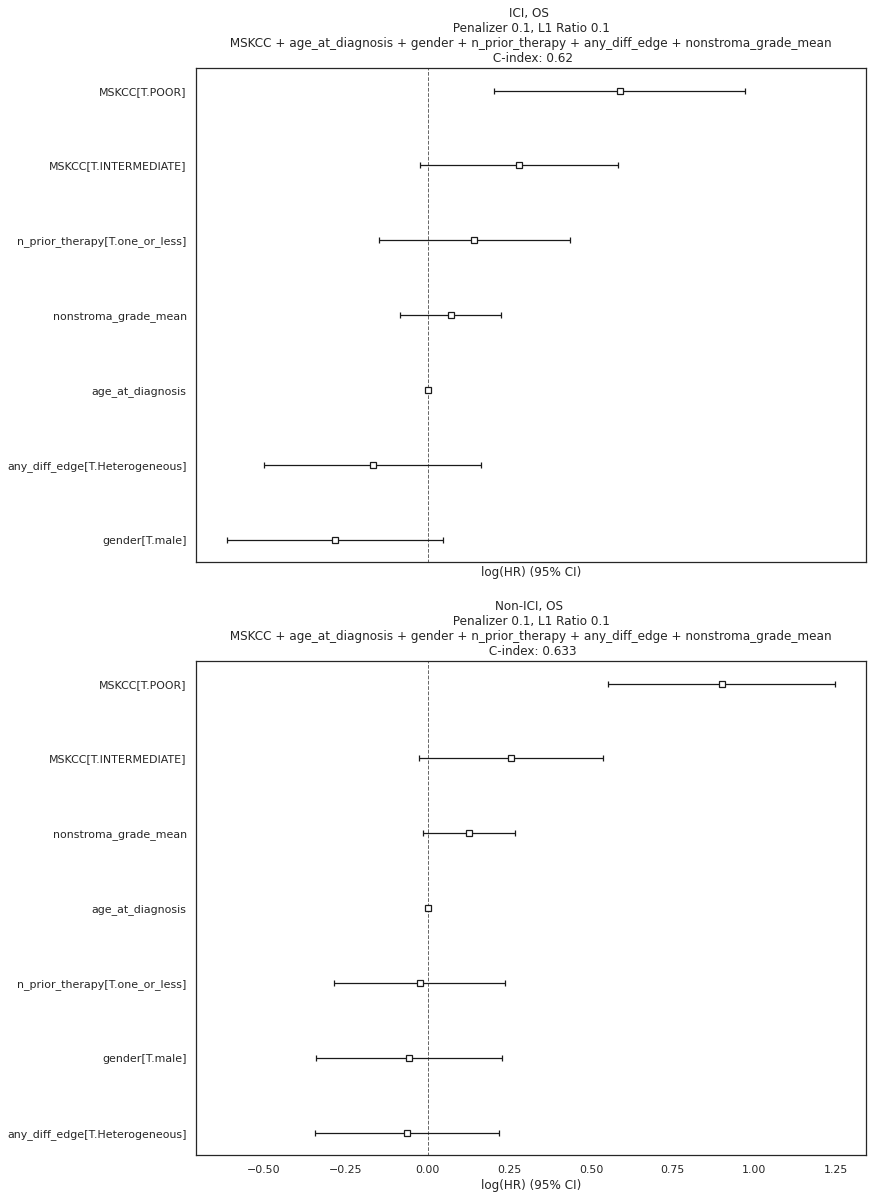

In [68]:
set_rc(12,6)

# form = max_form
form = 'MSKCC + age_at_diagnosis + gender + n_prior_therapy + any_diff_edge + nonstroma_grade_mean'

for k,v in reg_sweep.items():
    print(k)
    penalizer = v['penalizer']
    l1_ratio = v['l1_ratio']

    
    fig, axes = plt.subplots(2,1, sharex=True, sharey=False, figsize=(12,20))
    crit = (result_agg['penalizer'] == penalizer) & (result_agg['l1_ratio'] == l1_ratio) & (result_agg['drug_type'] == 'ICI')
    crit = crit & (result_agg['duration_var'] == 'os') & (result_agg['drop_intermed_group'] == False)
    cindex=result_agg.loc[crit].loc[form,'concordance_index_']

    axes[0].set_title(f'ICI, OS \n Penalizer {penalizer}, L1 Ratio {l1_ratio} \n {form} \n C-index: {cindex.round(3)}')
    cph_results['os_ICI_only_including_intermediate_benefit'][f'{form}|{penalizer}_{l1_ratio}'].plot(ax=axes[0])

    crit = (result_agg['penalizer'] == penalizer) & (result_agg['l1_ratio'] == l1_ratio) & (result_agg['drug_type'] == 'Non-ICI')
    crit = crit & (result_agg['duration_var'] == 'os') & (result_agg['drop_intermed_group'] == False)
    cindex=result_agg.loc[crit].loc[form,'concordance_index_']

    axes[1].set_title(f'Non-ICI, OS \n Penalizer {penalizer}, L1 Ratio {l1_ratio} \n {form} \n C-index: {cindex.round(3)}')
    cph_results['os_Non-ICI_only_including_intermediate_benefit'][f'{form}|{penalizer}_{l1_ratio}'].plot(ax=axes[1])

#     plt.savefig(f'./main_figs/simple_cph_comparison_no_interaction_NONTIL Penalizer {penalizer}, L1 Ratio {l1_ratio}.png', bbox_inches='tight')
    plt.show()

In [69]:
aggregate_formulas

['MSKCC + grade + age_at_diagnosis + gender + n_prior_therapy',
 'nonstroma_grade_mean',
 'any_diff_edge',
 'any_diff_edge + nonstroma_grade_mean',
 'any_diff_edge : nonstroma_grade_mean',
 'combined_total_weighted_edge_score + nonstroma_grade_mean',
 'combined_total_weighted_edge_score + any_diff_edge + nonstroma_grade_mean',
 'combined_total_weighted_edge_score + any_diff_edge : nonstroma_grade_mean',
 'MSKCC + age_at_diagnosis + gender + n_prior_therapy + any_diff_edge + nonstroma_grade_mean',
 'MSKCC + age_at_diagnosis + gender + n_prior_therapy + combined_total_weighted_edge_score + nonstroma_grade_mean',
 'MSKCC + age_at_diagnosis + gender + n_prior_therapy + combined_total_weighted_edge_score + any_diff_edge + nonstroma_grade_mean',
 'MSKCC + age_at_diagnosis + gender + n_prior_therapy + combined_total_weighted_edge_score + any_diff_edge : nonstroma_grade_mean']

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


only_clinical_vars
default


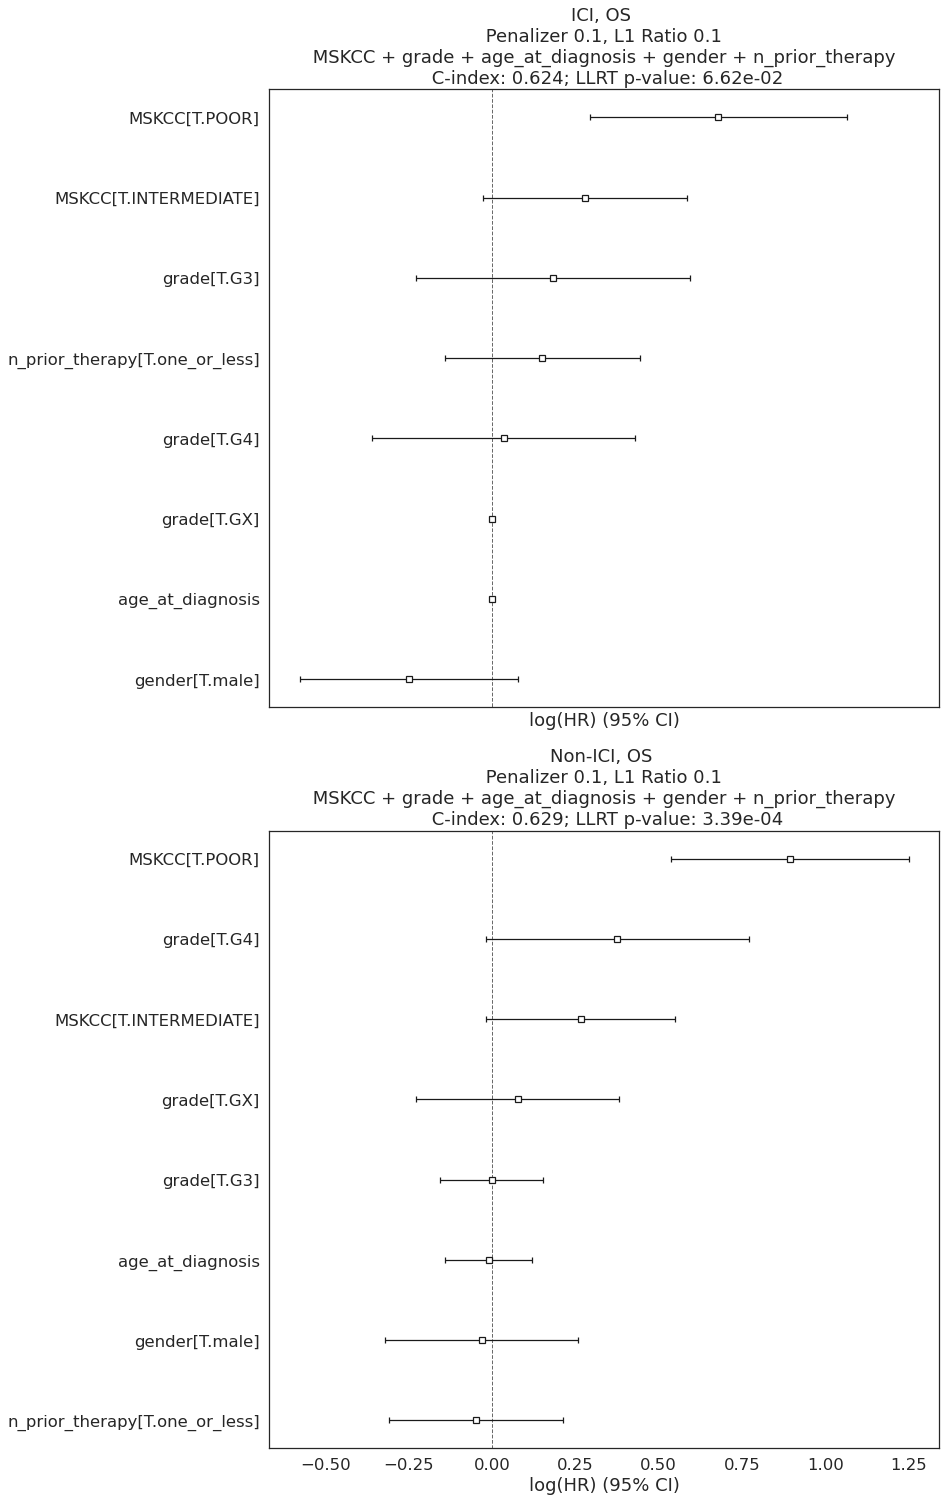

clinical_vars_and_binary_het
default


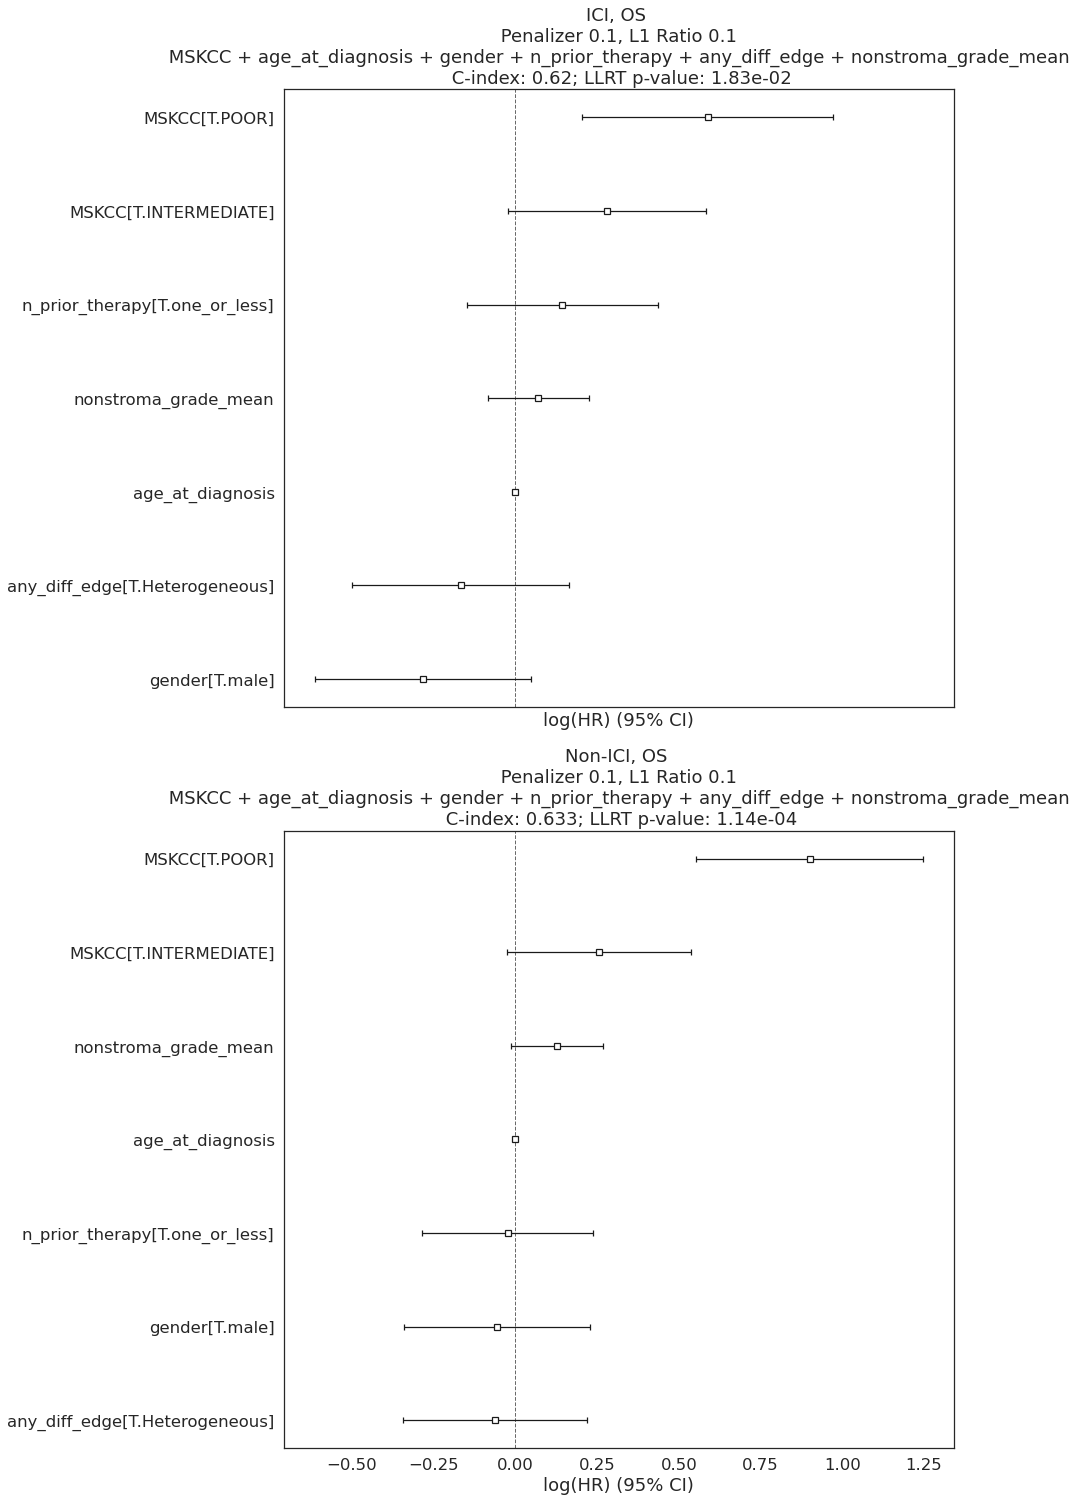

clinical_vars_and_continuous_het
default


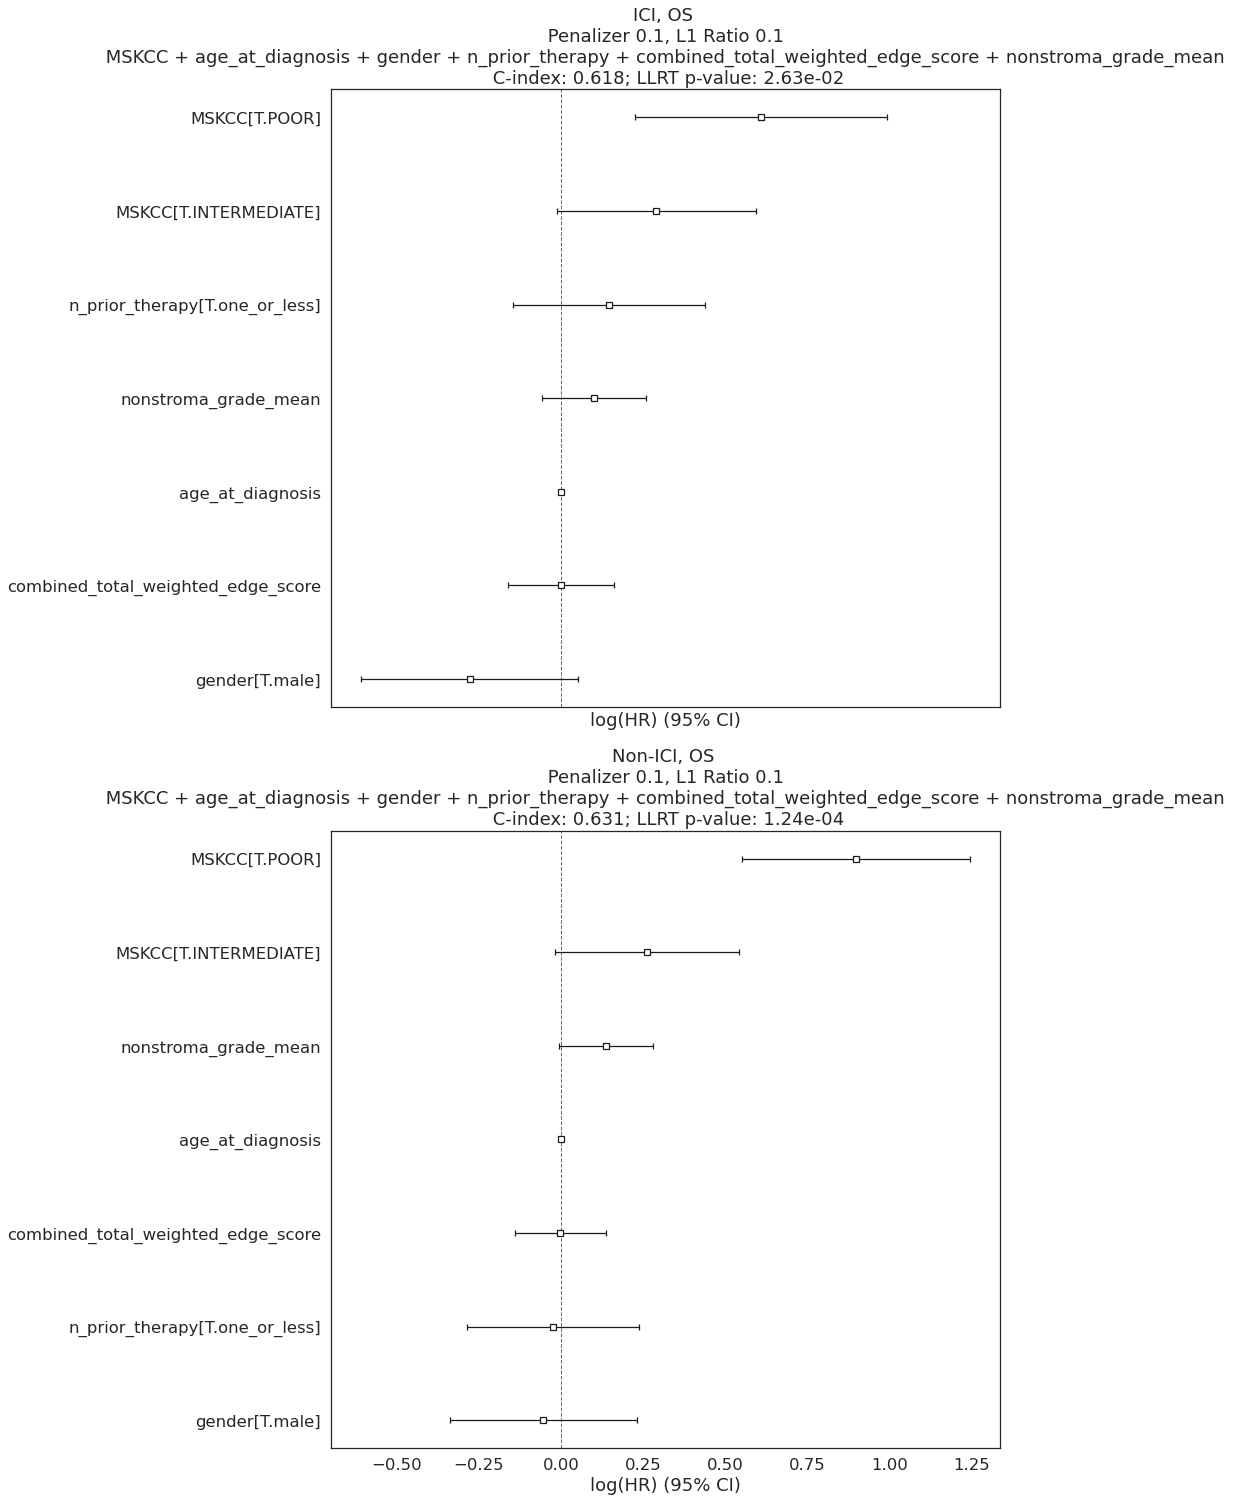

In [70]:
set_rc(12,25, 1.5)
cph_results = deepcopy(grouped_results['nontil'])
result_agg = pd.read_csv('./[rerun] cm025_cph_sweep_results_unfiltered.csv',index_col=0)

form_map = {
    'only_clinical_vars':'MSKCC + grade + age_at_diagnosis + gender + n_prior_therapy',
    'clinical_vars_and_binary_het':'MSKCC + age_at_diagnosis + gender + n_prior_therapy + any_diff_edge + nonstroma_grade_mean',
    'clinical_vars_and_continuous_het':'MSKCC + age_at_diagnosis + gender + n_prior_therapy + combined_total_weighted_edge_score + nonstroma_grade_mean',
}

for name, form in form_map.items():
    print(name)
    for k,v in reg_sweep.items():
        print(k)
        penalizer = v['penalizer']
        l1_ratio = v['l1_ratio']


        fig, axes = plt.subplots(2,1, sharex=True, sharey=False)
        crit = (result_agg['penalizer'] == penalizer) & (result_agg['l1_ratio'] == l1_ratio) & (result_agg['drug_type'] == 'ICI')
        crit = crit & (result_agg['duration_var'] == 'os') & (result_agg['drop_intermed_group'] == False)
        cindex=result_agg.loc[crit].loc[form,'concordance_index_']
        
        subresult = cph_results['os_ICI_only_including_intermediate_benefit'][f'{form}|{penalizer}_{l1_ratio}']
        pval = subresult.log_likelihood_ratio_test().summary['p'].item()
        axes[0].set_title(f'ICI, OS \n Penalizer {penalizer}, L1 Ratio {l1_ratio} \n {form} \n C-index: {cindex.round(3)}; LLRT p-value: {pval :.2e}')
        subresult.plot(ax=axes[0])

        crit = (result_agg['penalizer'] == penalizer) & (result_agg['l1_ratio'] == l1_ratio) & (result_agg['drug_type'] == 'Non-ICI')
        crit = crit & (result_agg['duration_var'] == 'os') & (result_agg['drop_intermed_group'] == False)
        cindex=result_agg.loc[crit].loc[form,'concordance_index_']
        
        subresult = cph_results['os_Non-ICI_only_including_intermediate_benefit'][f'{form}|{penalizer}_{l1_ratio}']
        pval = subresult.log_likelihood_ratio_test().summary['p'].item()
        axes[1].set_title(f'Non-ICI, OS \n Penalizer {penalizer}, L1 Ratio {l1_ratio} \n {form} \n C-index: {cindex.round(3)}; LLRT p-value: {pval :.2e}')
        subresult.plot(ax=axes[1])

        plt.savefig(f'./main_figs/simple_cph_comparison_no_interaction_NONTIL __ {name} __ Penalizer {penalizer}, L1 Ratio {l1_ratio}.png', bbox_inches='tight')
        plt.show()

only_clinical_vars
default


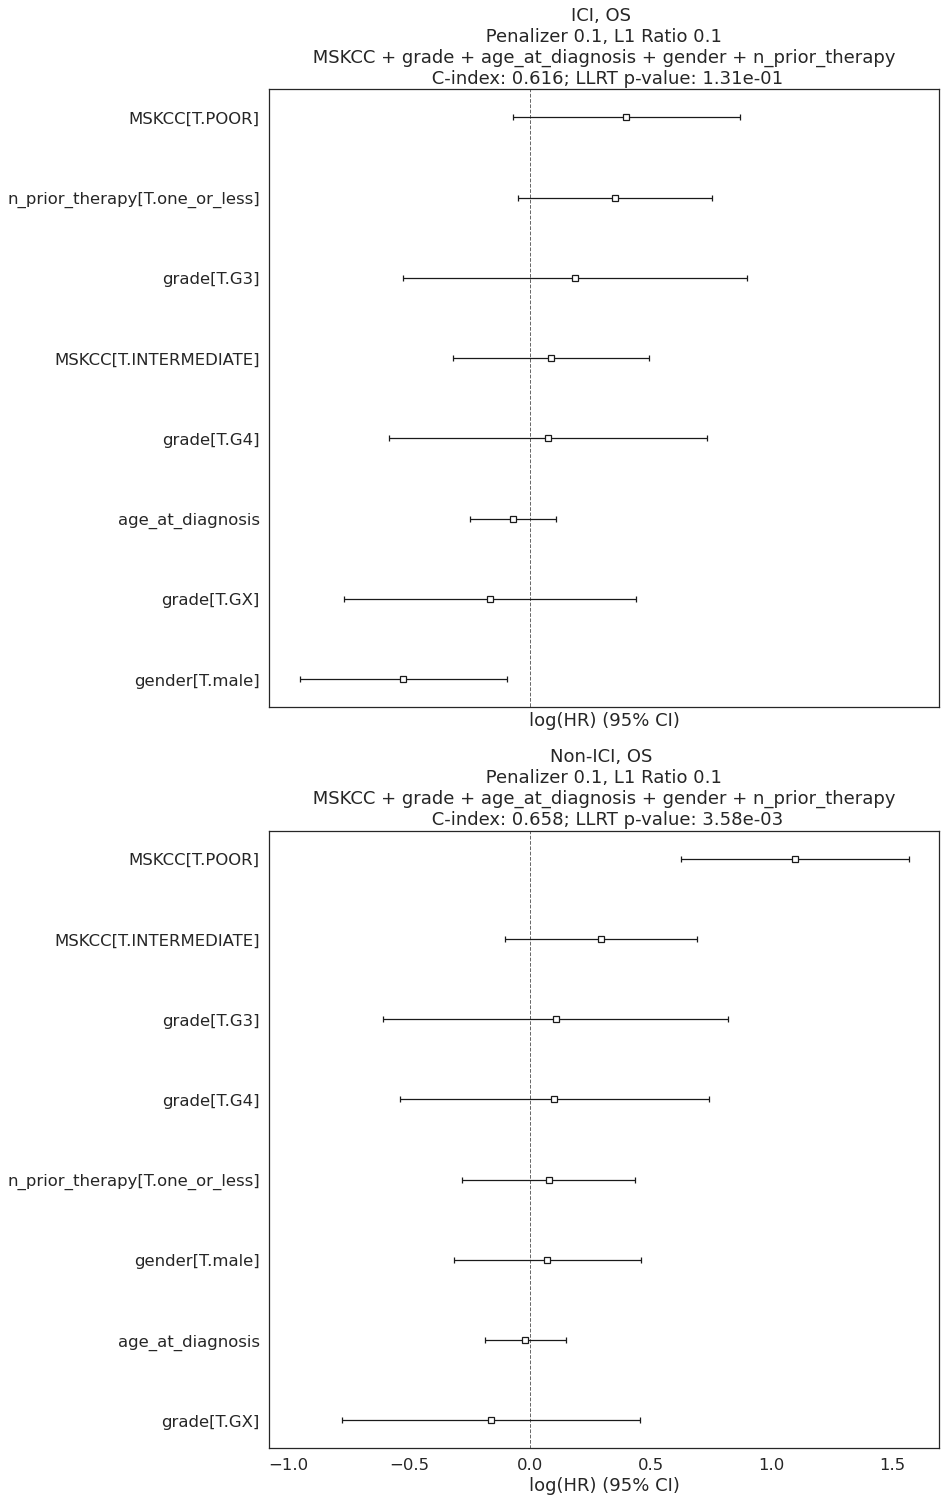

clinical_vars_and_binary_infilt
default


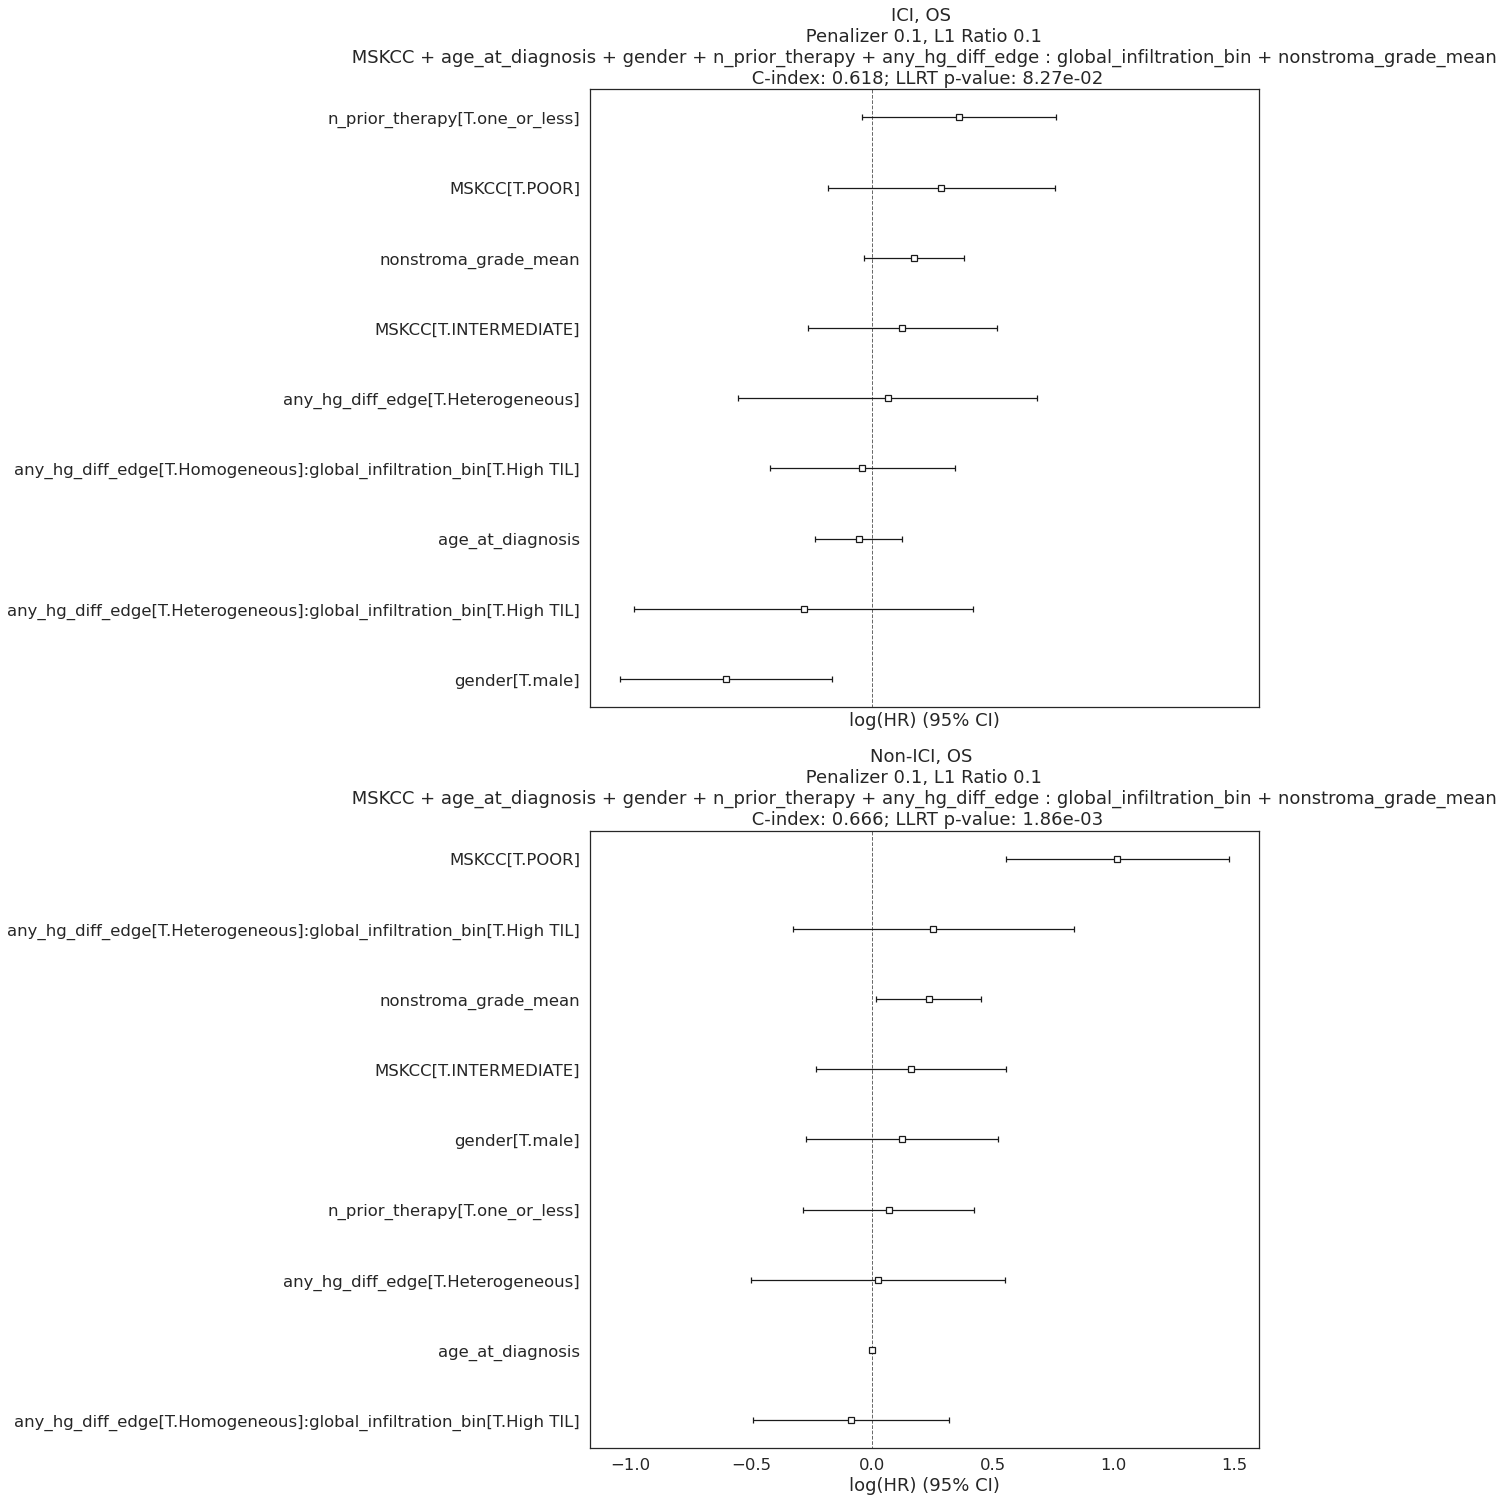

clinical_vars_and_continuous_infilt
default


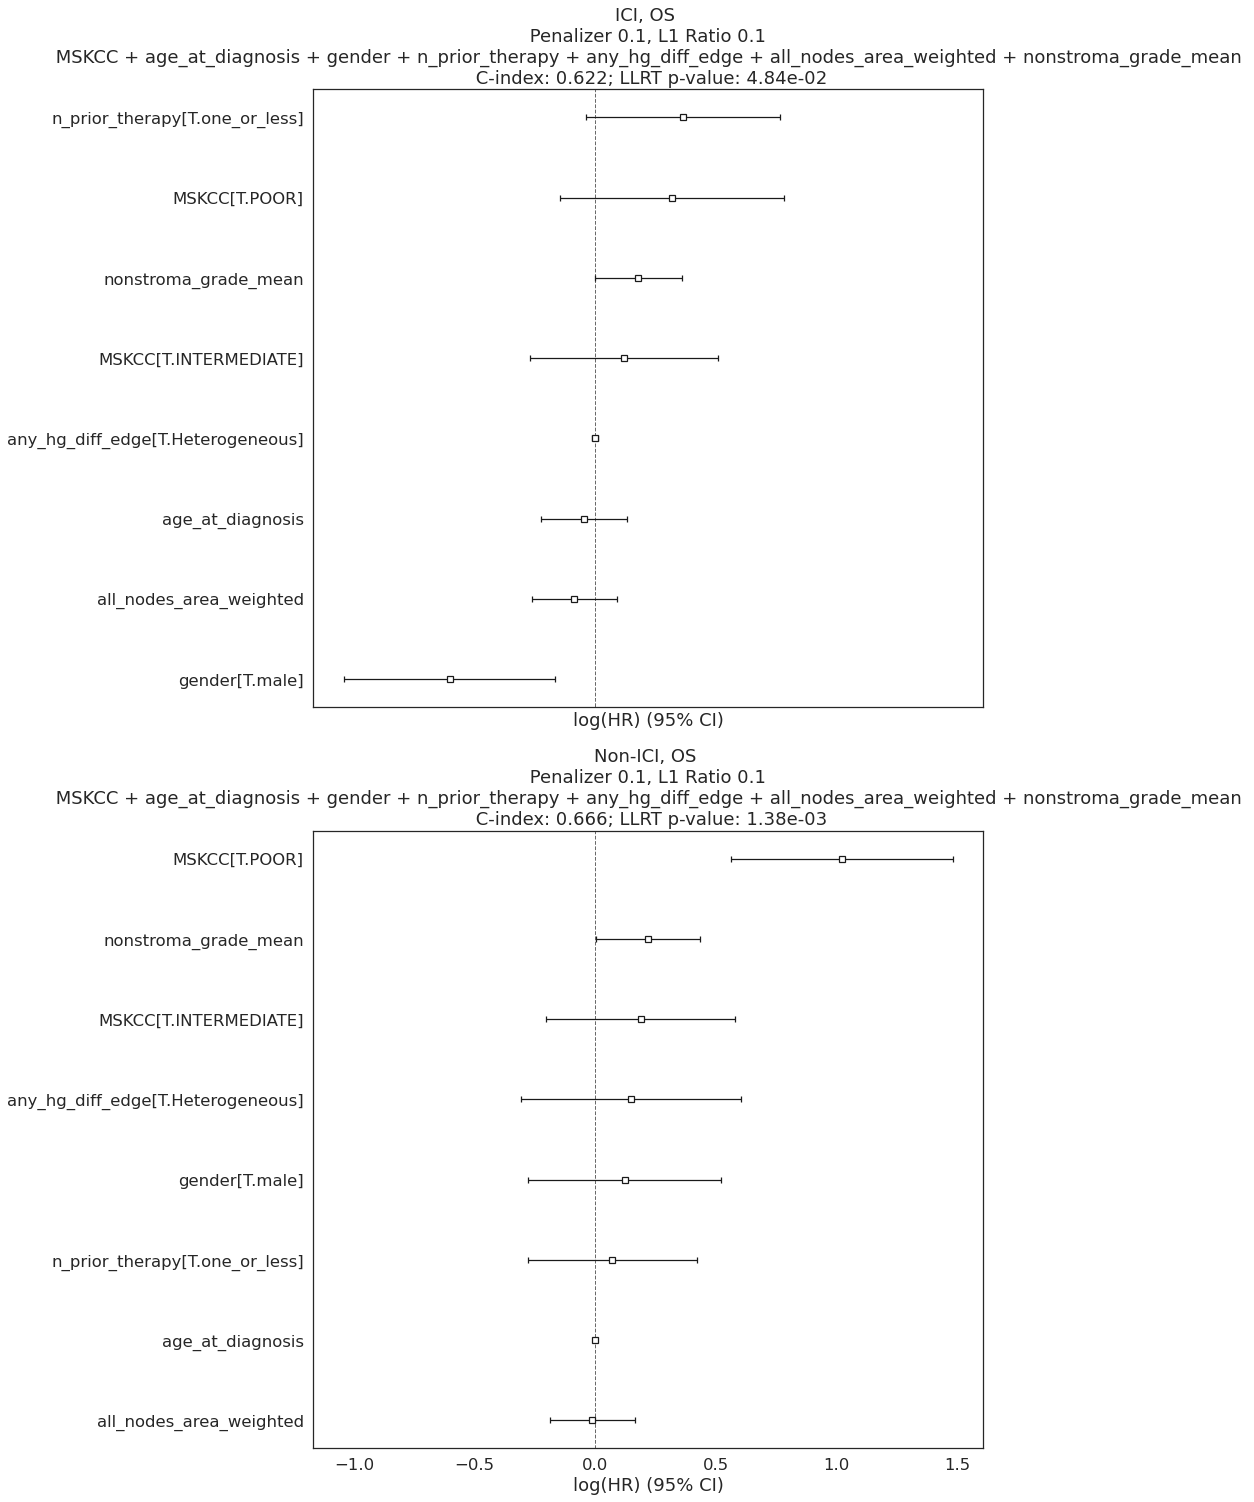

In [71]:
set_rc(12,25, 1.5)
cph_results = torch.load('./[rerun] cm025 CPH sweep fitter results.pkl')['til']
result_agg = pd.read_csv('./[rerun] cm025_cph_sweep_results_hg_and_til_required.csv',index_col=0)

form_map = {
    'only_clinical_vars':'MSKCC + grade + age_at_diagnosis + gender + n_prior_therapy',
    'clinical_vars_and_binary_infilt':'MSKCC + age_at_diagnosis + gender + n_prior_therapy + any_hg_diff_edge : global_infiltration_bin + nonstroma_grade_mean',
    'clinical_vars_and_continuous_infilt':'MSKCC + age_at_diagnosis + gender + n_prior_therapy + any_hg_diff_edge + all_nodes_area_weighted + nonstroma_grade_mean',
}

for name, form in form_map.items():
    print(name)
    for k,v in reg_sweep.items():
        print(k)
        penalizer = v['penalizer']
        l1_ratio = v['l1_ratio']


        fig, axes = plt.subplots(2,1, sharex=True, sharey=False)
        crit = (result_agg['penalizer'] == penalizer) & (result_agg['l1_ratio'] == l1_ratio) & (result_agg['drug_type'] == 'ICI')
        crit = crit & (result_agg['duration_var'] == 'os') & (result_agg['drop_intermed_group'] == False)
        cindex=result_agg.loc[crit].loc[form,'concordance_index_']
        
        subresult = cph_results['os_ICI_only_including_intermediate_benefit'][f'{form}|{penalizer}_{l1_ratio}']
        pval = subresult.log_likelihood_ratio_test().summary['p'].item()
        axes[0].set_title(f'ICI, OS \n Penalizer {penalizer}, L1 Ratio {l1_ratio} \n {form} \n C-index: {cindex.round(3)}; LLRT p-value: {pval :.2e}')
        subresult.plot(ax=axes[0])

        crit = (result_agg['penalizer'] == penalizer) & (result_agg['l1_ratio'] == l1_ratio) & (result_agg['drug_type'] == 'Non-ICI')
        crit = crit & (result_agg['duration_var'] == 'os') & (result_agg['drop_intermed_group'] == False)
        cindex=result_agg.loc[crit].loc[form,'concordance_index_']
        
        subresult = cph_results['os_Non-ICI_only_including_intermediate_benefit'][f'{form}|{penalizer}_{l1_ratio}']
        pval = subresult.log_likelihood_ratio_test().summary['p'].item()
        axes[1].set_title(f'Non-ICI, OS \n Penalizer {penalizer}, L1 Ratio {l1_ratio} \n {form} \n C-index: {cindex.round(3)}; LLRT p-value: {pval :.2e}')
        subresult.plot(ax=axes[1])

        plt.savefig(f'./main_figs/simple_cph_comparison_TIL __ {name} __ Penalizer {penalizer}, L1 Ratio {l1_ratio}.png', bbox_inches='tight')
        plt.show()

only_clinical_vars
default


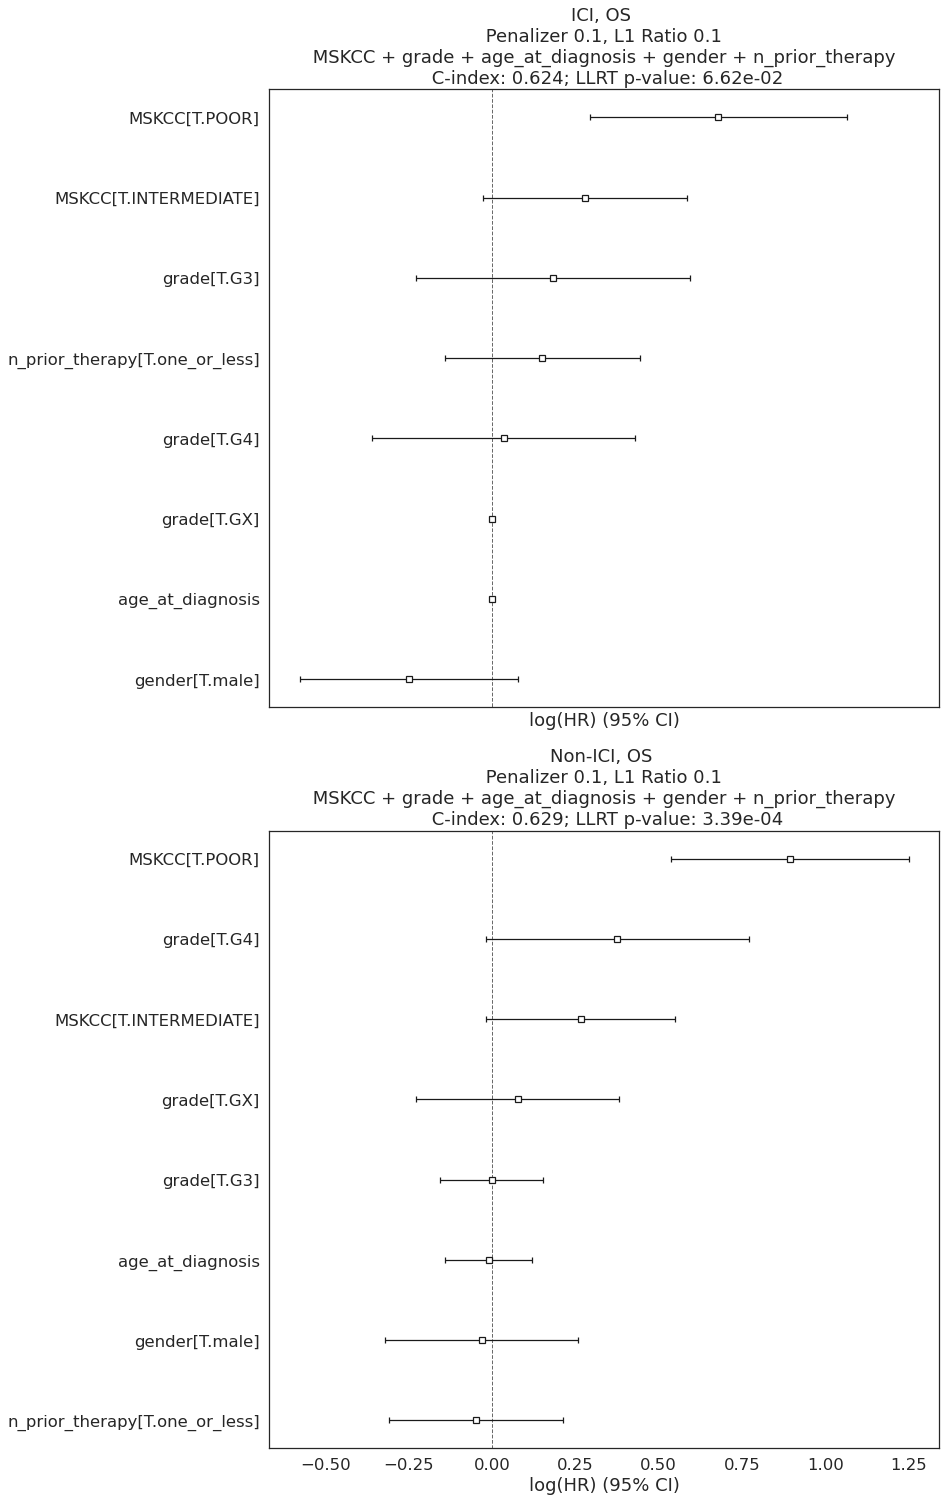

clinical_vars_and_binary_het
default


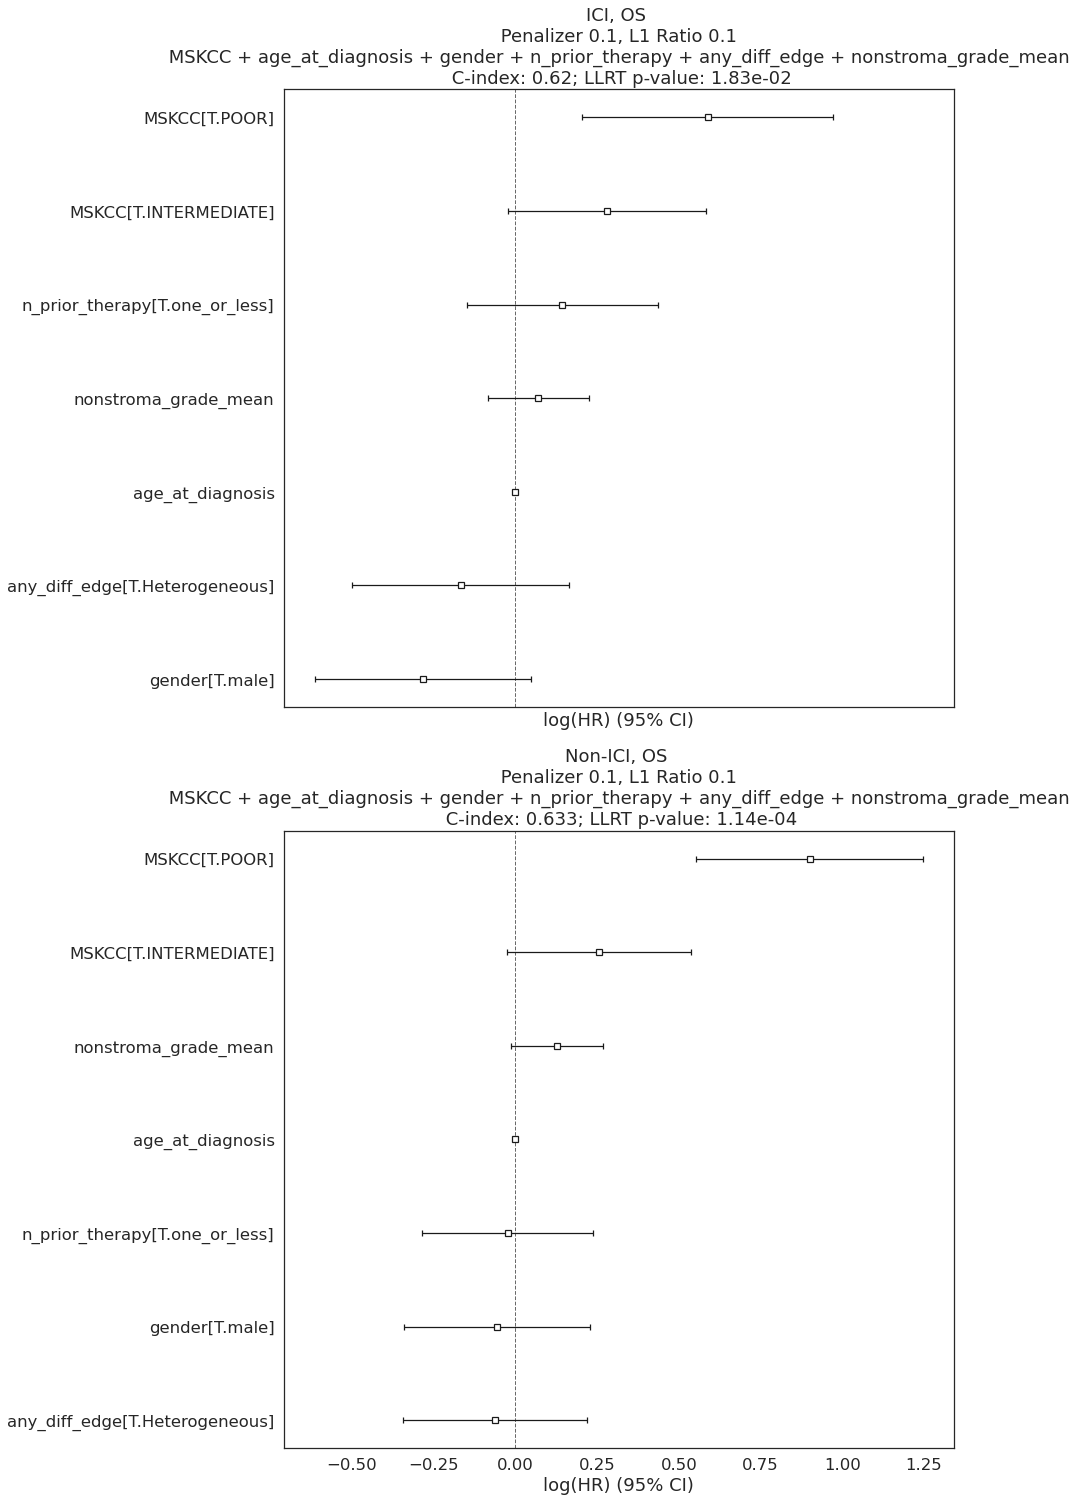

clinical_vars_and_continuous_het
default


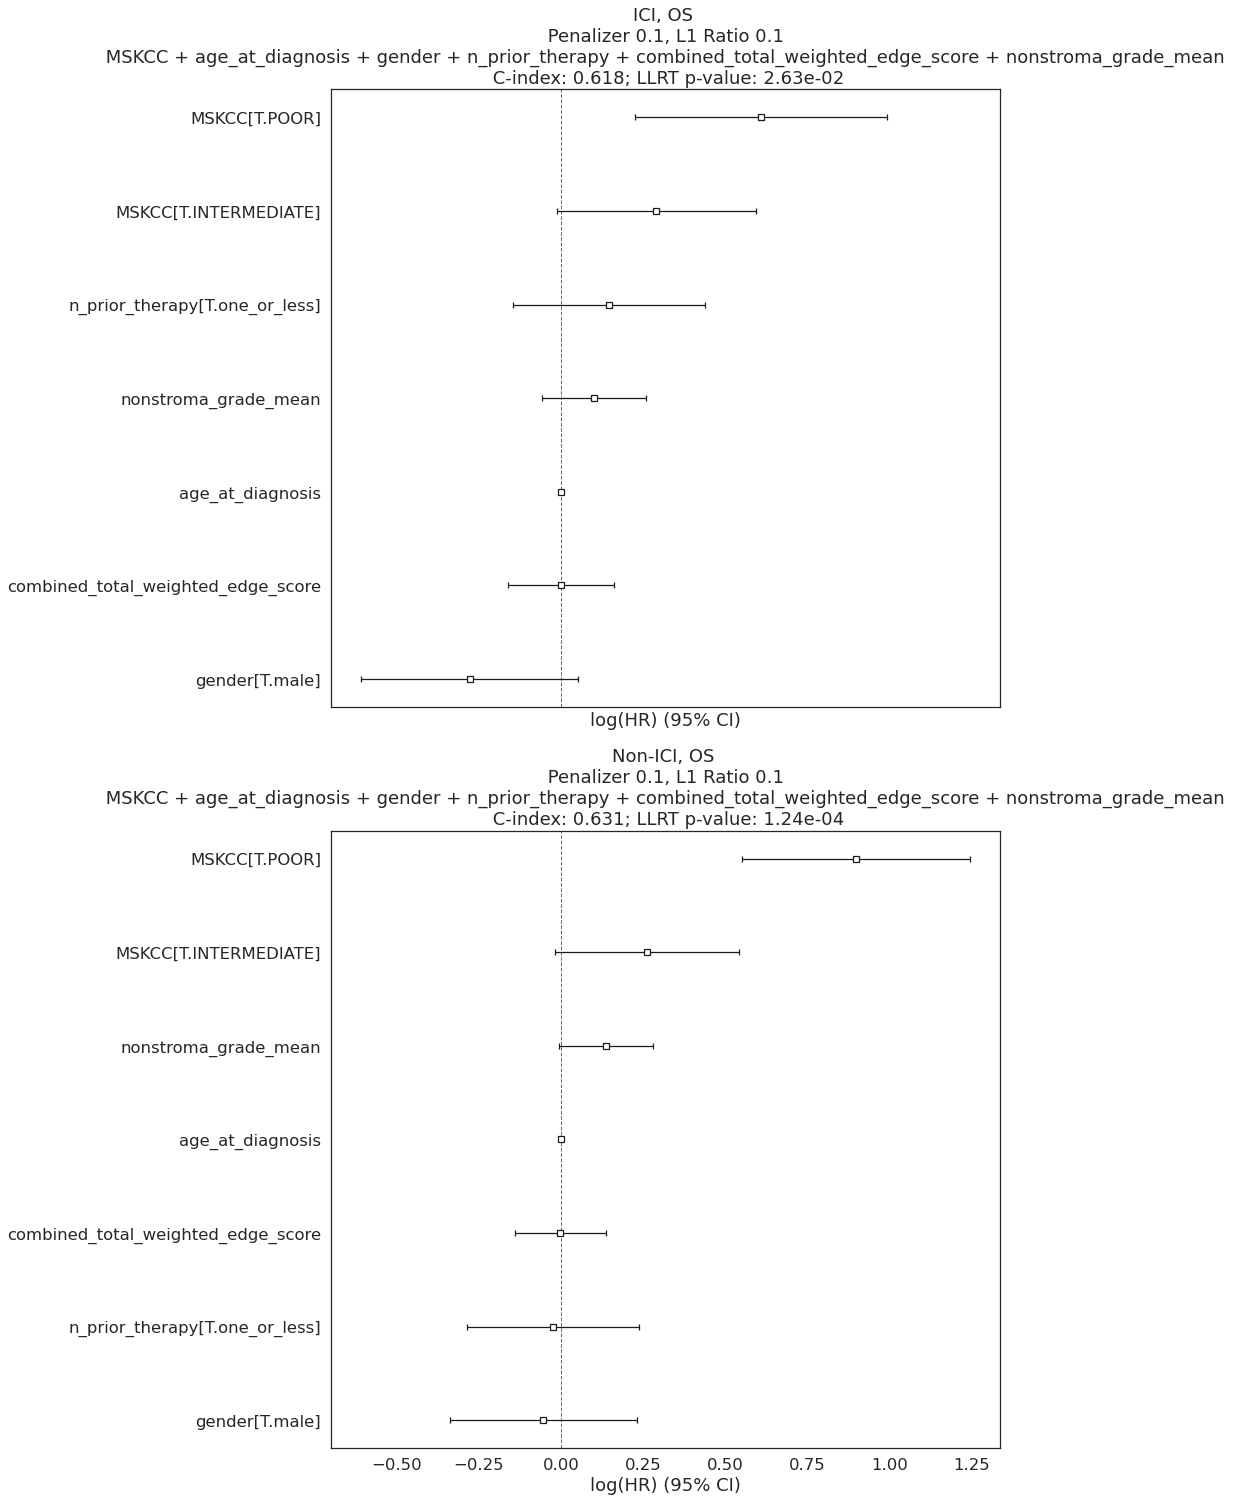

In [72]:
set_rc(12,25, 1.5)
cph_results = torch.load('./[rerun] cm025 CPH sweep fitter results.pkl')['nontil']
result_agg = pd.read_csv('./[rerun] cm025_cph_sweep_results_unfiltered.csv',index_col=0)

form_map = {
    'only_clinical_vars':'MSKCC + grade + age_at_diagnosis + gender + n_prior_therapy',
    'clinical_vars_and_binary_het':'MSKCC + age_at_diagnosis + gender + n_prior_therapy + any_diff_edge + nonstroma_grade_mean',
    'clinical_vars_and_continuous_het':'MSKCC + age_at_diagnosis + gender + n_prior_therapy + combined_total_weighted_edge_score + nonstroma_grade_mean',
}

for name, form in form_map.items():
    print(name)
    for k,v in reg_sweep.items():
        print(k)
        penalizer = v['penalizer']
        l1_ratio = v['l1_ratio']


        fig, axes = plt.subplots(2,1, sharex=True, sharey=False)
        crit = (result_agg['penalizer'] == penalizer) & (result_agg['l1_ratio'] == l1_ratio) & (result_agg['drug_type'] == 'ICI')
        crit = crit & (result_agg['duration_var'] == 'os') & (result_agg['drop_intermed_group'] == False)
        cindex=result_agg.loc[crit].loc[form,'concordance_index_']
        
        subresult = cph_results['os_ICI_only_including_intermediate_benefit'][f'{form}|{penalizer}_{l1_ratio}']
        pval = subresult.log_likelihood_ratio_test().summary['p'].item()
        axes[0].set_title(f'ICI, OS \n Penalizer {penalizer}, L1 Ratio {l1_ratio} \n {form} \n C-index: {cindex.round(3)}; LLRT p-value: {pval :.2e}')
        subresult.plot(ax=axes[0])

        crit = (result_agg['penalizer'] == penalizer) & (result_agg['l1_ratio'] == l1_ratio) & (result_agg['drug_type'] == 'Non-ICI')
        crit = crit & (result_agg['duration_var'] == 'os') & (result_agg['drop_intermed_group'] == False)
        cindex=result_agg.loc[crit].loc[form,'concordance_index_']
        
        subresult = cph_results['os_Non-ICI_only_including_intermediate_benefit'][f'{form}|{penalizer}_{l1_ratio}']
        pval = subresult.log_likelihood_ratio_test().summary['p'].item()
        axes[1].set_title(f'Non-ICI, OS \n Penalizer {penalizer}, L1 Ratio {l1_ratio} \n {form} \n C-index: {cindex.round(3)}; LLRT p-value: {pval :.2e}')
        subresult.plot(ax=axes[1])

        plt.savefig(f'./main_figs/simple_cph_comparison_no_interaction_NONTIL __ {name} __ Penalizer {penalizer}, L1 Ratio {l1_ratio}.png', bbox_inches='tight')
        plt.show()

default


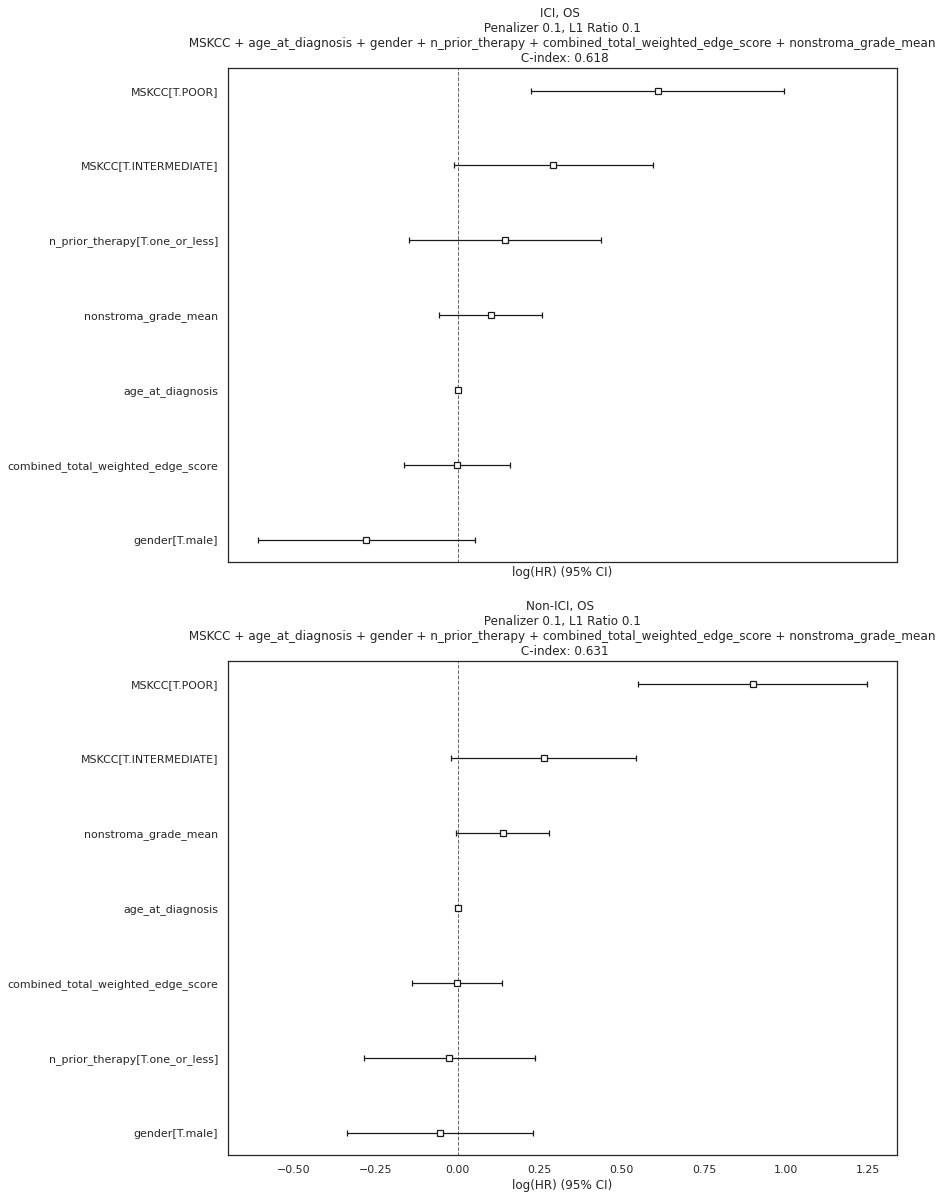

In [73]:
set_rc(12,6)

form = 'MSKCC + age_at_diagnosis + gender + n_prior_therapy + combined_total_weighted_edge_score + nonstroma_grade_mean'

for k,v in reg_sweep.items():
    print(k)
    penalizer = v['penalizer']
    l1_ratio = v['l1_ratio']

    
    fig, axes = plt.subplots(2,1, sharex=True, sharey=False, figsize=(12,20))
    crit = (result_agg['penalizer'] == penalizer) & (result_agg['l1_ratio'] == l1_ratio) & (result_agg['drug_type'] == 'ICI')
    crit = crit & (result_agg['duration_var'] == 'os') & (result_agg['drop_intermed_group'] == False)
    cindex=result_agg.loc[crit].loc[form,'concordance_index_']

    axes[0].set_title(f'ICI, OS \n Penalizer {penalizer}, L1 Ratio {l1_ratio} \n {form} \n C-index: {cindex.round(3)}')
    cph_results['os_ICI_only_including_intermediate_benefit'][f'{form}|{penalizer}_{l1_ratio}'].plot(ax=axes[0])

    crit = (result_agg['penalizer'] == penalizer) & (result_agg['l1_ratio'] == l1_ratio) & (result_agg['drug_type'] == 'Non-ICI')
    crit = crit & (result_agg['duration_var'] == 'os') & (result_agg['drop_intermed_group'] == False)
    cindex=result_agg.loc[crit].loc[form,'concordance_index_']

    axes[1].set_title(f'Non-ICI, OS \n Penalizer {penalizer}, L1 Ratio {l1_ratio} \n {form} \n C-index: {cindex.round(3)}')
    cph_results['os_Non-ICI_only_including_intermediate_benefit'][f'{form}|{penalizer}_{l1_ratio}'].plot(ax=axes[1])

#     plt.savefig(f'./main_figs/simple_cph_comparison_no_interaction_NONTIL Penalizer {penalizer}, L1 Ratio {l1_ratio}.png', bbox_inches='tight')
    plt.show()